In [48]:
import pandas as pd

# Ruta de archivo
ruta_inv = r"E:\Trabajo\Analisis_Datos\Proyecto\Datos\Inventario\CSV\INV3.csv"

# Leer CSV
df = pd.read_csv(ruta_inv)

# 1️⃣ Intentar convertir a fecha, forzando formato día-mes-año
df["Fecha_Limpia"] = pd.to_datetime(df["Fecha"], format="%d-%m-%y", errors="coerce")

# Si hay NaT, intentar con %d-%m-%Y
mask_nat = df["Fecha_Limpia"].isna()
df.loc[mask_nat, "Fecha_Limpia"] = pd.to_datetime(df.loc[mask_nat, "Fecha"], format="%d-%m-%Y", errors="coerce")

# 2️⃣ Eliminar filas con fecha inválida
df = df.dropna(subset=["Fecha_Limpia"])

# 3️⃣ Filtrar desde el año 2000 en adelante
df = df[df["Fecha_Limpia"].dt.year >= 2000]

# 4️⃣ Eliminar fechas con día = 1
df = df[df["Fecha_Limpia"].dt.day != 1]

# 5️⃣ Guardar limpio
ruta_salida = r"E:\Trabajo\Analisis_Datos\Proyecto\Datos\Inventario\CSV\INV3_filtrado.csv"
df.to_csv(ruta_salida, index=False)

print(f"✅ Inventario filtrado guardado en: {ruta_salida}")





✅ Inventario filtrado guardado en: E:\Trabajo\Analisis_Datos\Proyecto\Datos\Inventario\CSV\INV3_filtrado.csv


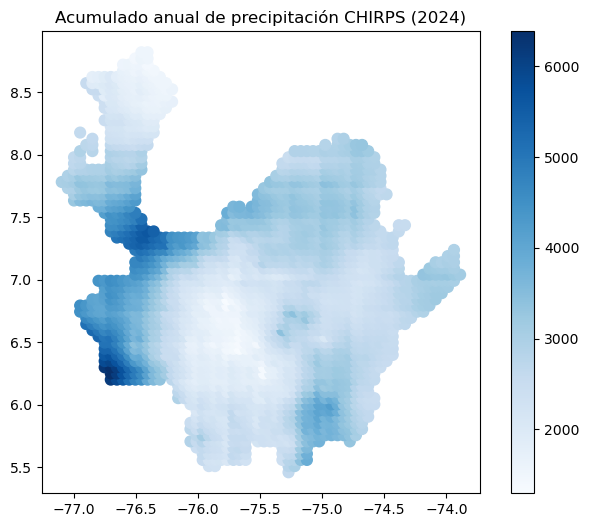

In [12]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Ruta de tu CSV
ruta_csv = r"E:\Trabajo\Analisis_Datos\Proyecto\Datos\Chirps\Precipitacion_Diaria_ANT2.csv"

# Leer CSV
df = pd.read_csv(ruta_csv)

# Extraer coordenadas desde el campo .geo
import json
df[["lon", "lat"]] = df[".geo"].apply(lambda x: pd.Series(json.loads(x)["coordinates"]))

# Convertir fecha a tipo datetime
df["fecha"] = pd.to_datetime(df["fecha"])

# Crear columna de año
df["anio"] = df["fecha"].dt.year

# Calcular acumulado anual por píxel
acumulado = df.groupby(["anio", "lat", "lon"])["precipitacion"].sum().reset_index()

# Seleccionar un año específico (ej. 2024)
acum_2024 = acumulado[acumulado["anio"] == 2024]

# Crear GeoDataFrame para graficar
gdf = gpd.GeoDataFrame(
    acum_2024,
    geometry=[Point(xy) for xy in zip(acum_2024.lon, acum_2024.lat)],
    crs="EPSG:4326"
)

# Graficar
fig, ax = plt.subplots(figsize=(8, 6))
gdf.plot(column="precipitacion", cmap="Blues", markersize=60, legend=True, ax=ax)
ax.set_title("Acumulado anual de precipitación CHIRPS (2024)")
plt.show()


Cargando datos CHIRPS...
Datos CHIRPS cargados: 19211624 registros, 2104 píxeles únicos
Rango temporal: 2000-01-01 00:00:00 a 2024-12-30 00:00:00

Cargando inventario de MM...
Columnas disponibles: ['Tipo', 'Fecha', 'Detonante', 'LAT', 'LONG', 'Fecha_Limpia']
Primeras filas:
          Tipo     Fecha    Detonante       LAT       LONG Fecha_Limpia
0               04-07-25               6.023000 -75.656961   2025-07-04
1        Flujo  19-06-25          NaN  6.042122 -75.702989   2025-06-19
2    Landslide  04-06-25  Other cause  5.794161 -75.840589   2025-06-04
3    Landslide  04-06-25  Other cause  5.794161 -75.840589   2025-06-04
4               03-06-25               5.781000 -75.659000   2025-06-03
5  Debris Flow  27-04-25     Rainfall  6.206013 -75.604455   2025-04-27
6    Landslide  09-04-25     Rainfall  5.874270 -75.567558   2025-04-09
7    Landslide  09-04-25     Rainfall  5.619989 -75.869006   2025-04-09
8               18-03-25               5.819568 -75.315000   2025-03-18
9   

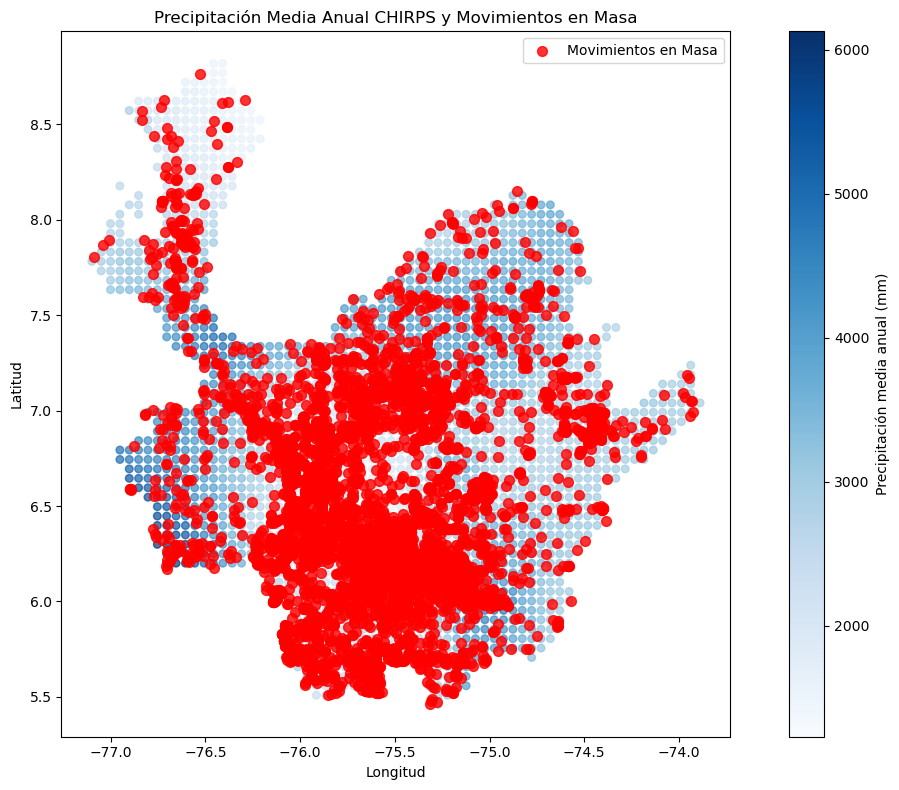

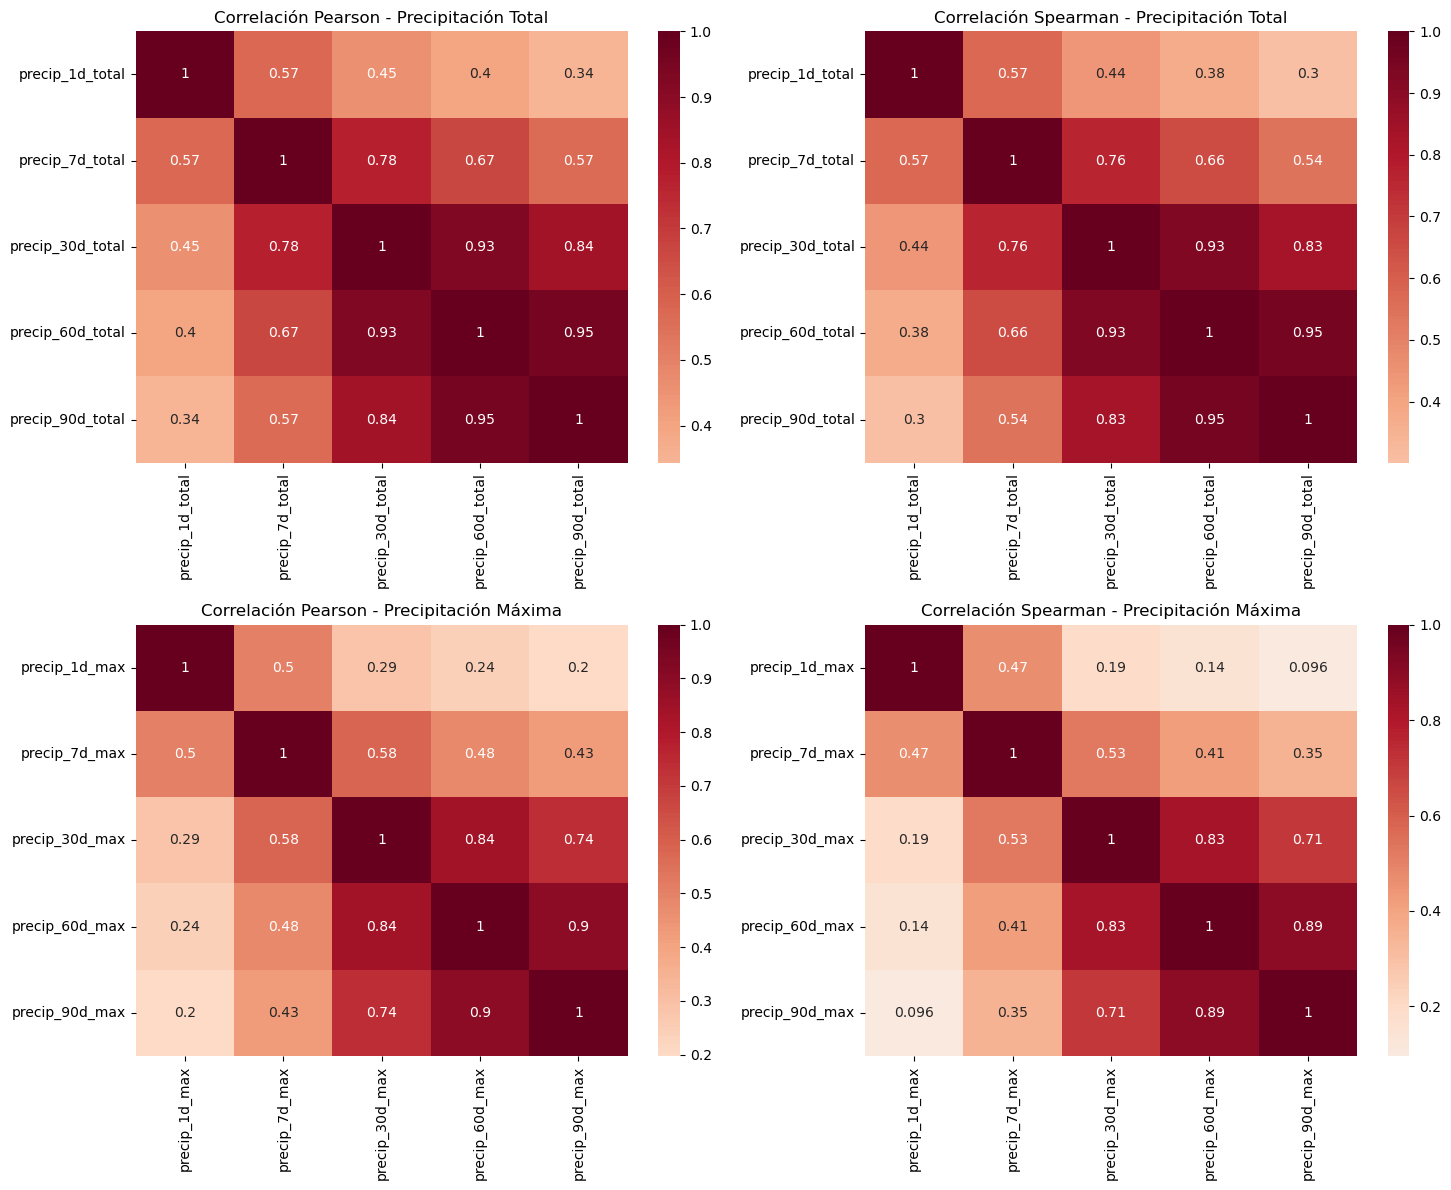

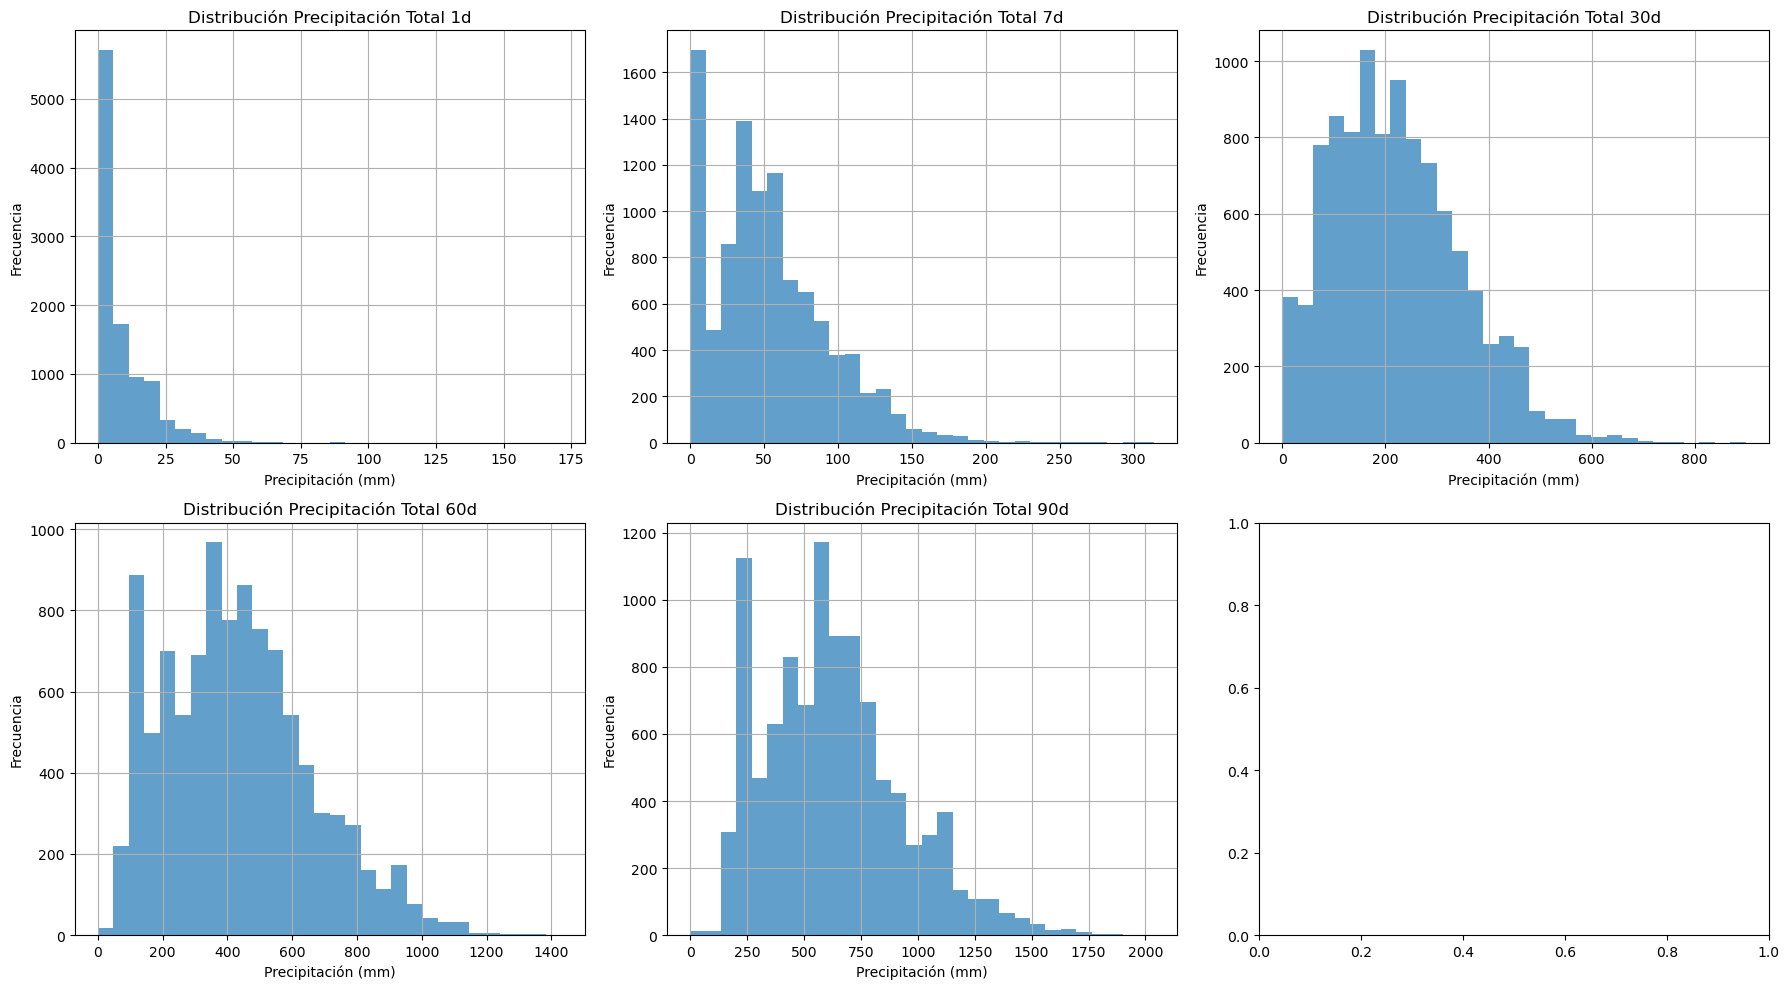

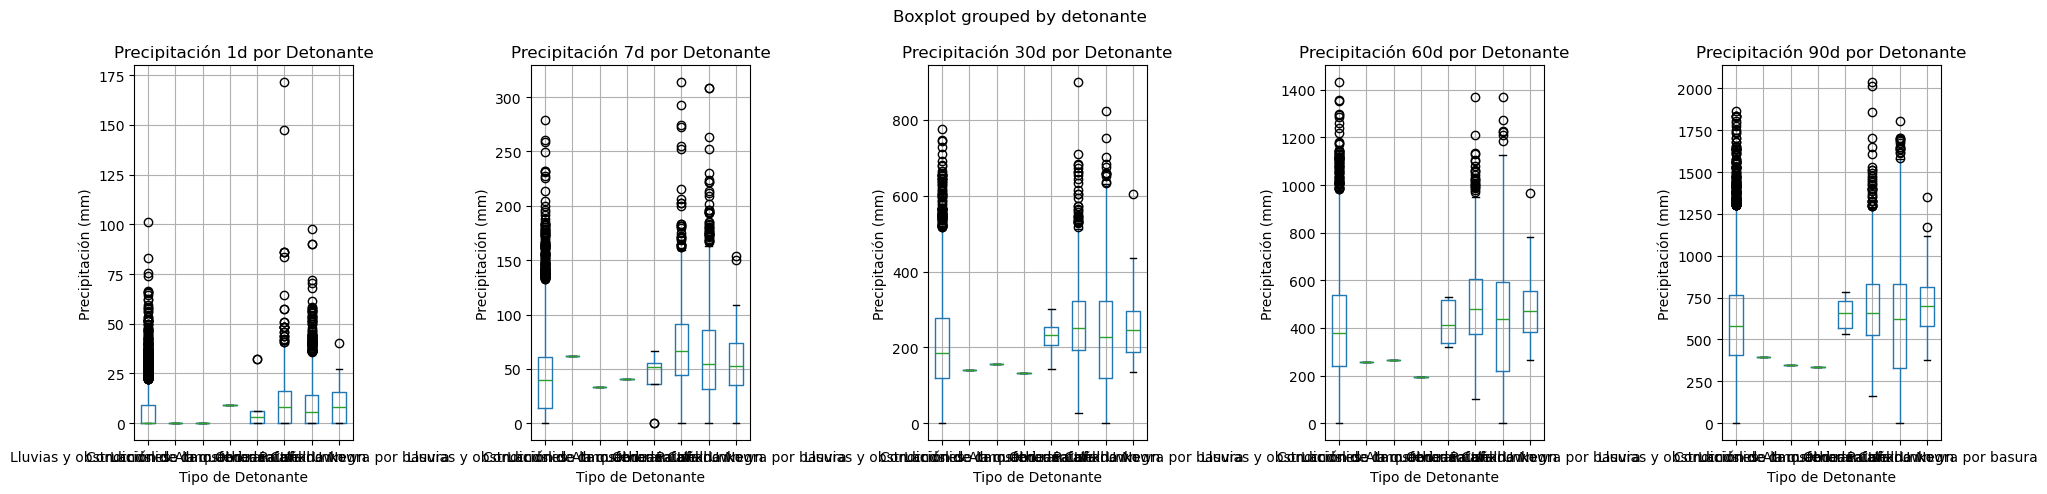


RESUMEN ESTADÍSTICO

Precipitación 1 días:
  Total - Media: 7.6mm, Mediana: 3.9mm, Std: 10.7mm
  Máxima - Media: 7.6mm

Precipitación 7 días:
  Total - Media: 53.3mm, Mediana: 47.8mm, Std: 40.0mm
  Máxima - Media: 20.6mm

Precipitación 30 días:
  Total - Media: 222.7mm, Mediana: 209.9mm, Std: 126.2mm
  Máxima - Media: 32.3mm

Precipitación 60 días:
  Total - Media: 432.7mm, Mediana: 413.2mm, Std: 226.9mm
  Máxima - Media: 37.7mm

Precipitación 90 días:
  Total - Media: 630.8mm, Mediana: 600.8mm, Std: 304.8mm
  Máxima - Media: 41.0mm

¡Análisis completado exitosamente!


In [62]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr, spearmanr
import json
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 1. CARGAR Y PROCESAR DATOS CHIRPS
# ============================================================================

def cargar_datos_chirps(ruta_csv):
    """Carga y procesa los datos CHIRPS"""
    print("Cargando datos CHIRPS...")
    df = pd.read_csv(ruta_csv)
    
    # Extraer coordenadas desde el campo .geo
    df[["lon", "lat"]] = df[".geo"].apply(lambda x: pd.Series(json.loads(x)["coordinates"]))
    
    # Convertir fecha a datetime
    df["fecha"] = pd.to_datetime(df["fecha"])
    
    # Crear identificador único de píxel
    df['pixel_id'] = df.groupby(['lat', 'lon']).ngroup()
    
    print(f"Datos CHIRPS cargados: {len(df)} registros, {df['pixel_id'].nunique()} píxeles únicos")
    print(f"Rango temporal: {df['fecha'].min()} a {df['fecha'].max()}")
    
    return df

def crear_grilla_pixeles(df_chirps):
    """Crear DataFrame con información de píxeles únicos"""
    pixeles = df_chirps[['pixel_id', 'lat', 'lon']].drop_duplicates().reset_index(drop=True)
    
    # Crear GeoDataFrame de píxeles
    geometry = [Point(xy) for xy in zip(pixeles.lon, pixeles.lat)]
    gdf_pixeles = gpd.GeoDataFrame(pixeles, geometry=geometry, crs="EPSG:4326")
    
    return pixeles, gdf_pixeles

# ============================================================================
# 2. CARGAR Y PROCESAR INVENTARIO DE MM
# ============================================================================

def cargar_inventario_mm(ruta_inv):
    """Carga y procesa el inventario de movimientos en masa"""
    print("\nCargando inventario de MM...")
    df_inv = pd.read_csv(ruta_inv)
    
    # Mostrar las primeras columnas para verificar formato
    print("Columnas disponibles:", df_inv.columns.tolist())
    print("Primeras filas:")
    print(df_inv.head(10))
    
    # Procesar fechas - CORREGIR: parece que las fechas son de 2024, no 2025
    # Intentar múltiples formatos de fecha
    df_inv['fecha_evento'] = None
    
    if 'Fecha_Limpia' in df_inv.columns:
        # Primero intentar como 2024
        df_inv['fecha_evento'] = pd.to_datetime(df_inv['Fecha_Limpia'].astype(str).str.replace('24', '24'), 
                                              format='%Y-%m-%d', errors='coerce')
        # Si no funciona, intentar formato dd-mm-yy pero interpretando como 2024
        mask_null = df_inv['fecha_evento'].isnull()
        if mask_null.any():
            fechas_alt = pd.to_datetime(df_inv.loc[mask_null, 'Fecha_Limpia'].astype(str).str.replace('-24', '-24'), 
                                       format='%d-%m-%y', errors='coerce')
            df_inv.loc[mask_null, 'fecha_evento'] = fechas_alt
    
    # También intentar con la columna 'Fecha' si existe
    if 'Fecha' in df_inv.columns:
        mask_null = df_inv['fecha_evento'].isnull()
        if mask_null.any():
            fechas_fecha = pd.to_datetime(df_inv.loc[mask_null, 'Fecha'].astype(str).str.replace('24', '24'), 
                                         format='%d-%m-%y', errors='coerce')
            df_inv.loc[mask_null, 'fecha_evento'] = fechas_fecha
    
    print(f"Fechas procesadas inicialmente: {df_inv['fecha_evento'].notna().sum()} de {len(df_inv)}")
    print("Rango de fechas detectado:", df_inv['fecha_evento'].min(), "a", df_inv['fecha_evento'].max())
    
    # Limpiar coordenadas
    df_inv['lat'] = pd.to_numeric(df_inv['LAT'], errors='coerce')
    df_inv['lon'] = pd.to_numeric(df_inv['LONG'], errors='coerce')
    
    # Mostrar estadísticas antes de filtrar
    print(f"Coordenadas válidas: {df_inv[['lat', 'lon']].notna().all(axis=1).sum()} de {len(df_inv)}")
    print(f"Fechas válidas: {df_inv['fecha_evento'].notna().sum()} de {len(df_inv)}")
    
    # Filtrar datos válidos (permitir algunos NaN en otras columnas)
    mask_validos = (df_inv['lat'].notna() & 
                    df_inv['lon'].notna() & 
                    df_inv['fecha_evento'].notna())
    
    df_inv = df_inv[mask_validos].reset_index(drop=True)
    
    # Rellenar valores faltantes en columnas categóricas
    df_inv['Tipo'] = df_inv['Tipo'].fillna('Unknown')
    df_inv['Detonante'] = df_inv['Detonante'].fillna('Unknown')
    
    print(f"MM procesados: {len(df_inv)} eventos válidos")
    if len(df_inv) > 0:
        print(f"Rango temporal MM: {df_inv['fecha_evento'].min()} a {df_inv['fecha_evento'].max()}")
        print("Tipos de MM:", df_inv['Tipo'].value_counts().to_dict())
        print("Detonantes:", df_inv['Detonante'].value_counts().to_dict())
    
    return df_inv

# ============================================================================
# 3. ASIGNACIÓN DE PÍXELES MÁS CERCANOS
# ============================================================================

def asignar_pixeles_mm(df_inv, pixeles):
    """Asigna a cada MM el píxel CHIRPS más cercano"""
    print("\nAsignando píxeles más cercanos a los MM...")
    
    # Coordenadas de los MM
    coords_mm = df_inv[['lat', 'lon']].values
    
    # Coordenadas de los píxeles CHIRPS
    coords_pixeles = pixeles[['lat', 'lon']].values
    
    # Calcular distancias y encontrar píxel más cercano
    distancias = cdist(coords_mm, coords_pixeles, metric='euclidean')
    indices_cercanos = np.argmin(distancias, axis=1)
    distancias_min = np.min(distancias, axis=1)
    
    # Asignar píxel más cercano
    df_inv['pixel_id'] = pixeles.iloc[indices_cercanos]['pixel_id'].values
    df_inv['pixel_lat'] = pixeles.iloc[indices_cercanos]['lat'].values
    df_inv['pixel_lon'] = pixeles.iloc[indices_cercanos]['lon'].values
    df_inv['distancia_pixel'] = distancias_min
    
    print(f"Distancia promedio al píxel más cercano: {distancias_min.mean():.4f}° ({distancias_min.mean()*111:.1f} km)")
    
    return df_inv

# ============================================================================
# 4. CÁLCULO DE PRECIPITACIÓN EN VENTANAS TEMPORALES
# ============================================================================

def calcular_precipitacion_ventanas(df_inv, df_chirps, ventanas=[1, 7, 30, 60, 90]):
    """Calcula precipitación acumulada en diferentes ventanas temporales"""
    print(f"\nCalculando precipitación para ventanas: {ventanas} días...")
    
    resultados = []
    
    for idx, row in df_inv.iterrows():
        if idx % 100 == 0:
            print(f"Procesando MM {idx+1}/{len(df_inv)}")
        
        pixel_id = row['pixel_id']
        fecha_evento = row['fecha_evento']
        
        # Filtrar datos del píxel específico
        datos_pixel = df_chirps[df_chirps['pixel_id'] == pixel_id].copy()
        
        if len(datos_pixel) == 0:
            continue
        
        # Calcular precipitación para cada ventana
        resultado = {
            'mm_id': idx,
            'pixel_id': pixel_id,
            'fecha_evento': fecha_evento,
            'lat_mm': row['lat'],
            'lon_mm': row['lon'],
            'pixel_lat': row['pixel_lat'],
            'pixel_lon': row['pixel_lon'],
            'distancia_pixel': row['distancia_pixel'],
            'tipo': row.get('Tipo', 'Unknown'),
            'detonante': row.get('Detonante', 'Unknown')
        }
        
        for ventana in ventanas:
            fecha_inicio = fecha_evento - pd.Timedelta(days=ventana-1)
            
            # Filtrar datos en la ventana temporal
            mask = (datos_pixel['fecha'] >= fecha_inicio) & (datos_pixel['fecha'] <= fecha_evento)
            datos_ventana = datos_pixel[mask]
            
            if len(datos_ventana) > 0:
                precip_total = datos_ventana['precipitacion'].sum()
                precip_max_dia = datos_ventana['precipitacion'].max()
                dias_con_lluvia = (datos_ventana['precipitacion'] > 0).sum()
                precip_promedio = datos_ventana['precipitacion'].mean()
            else:
                precip_total = np.nan
                precip_max_dia = np.nan
                dias_con_lluvia = 0
                precip_promedio = np.nan
            
            resultado[f'precip_{ventana}d_total'] = precip_total
            resultado[f'precip_{ventana}d_max'] = precip_max_dia
            resultado[f'precip_{ventana}d_promedio'] = precip_promedio
            resultado[f'dias_lluvia_{ventana}d'] = dias_con_lluvia
        
        resultados.append(resultado)
    
    df_resultados = pd.DataFrame(resultados)
    print(f"Calculada precipitación para {len(df_resultados)} MM")
    
    return df_resultados

# ============================================================================
# 5. ANÁLISIS DE CORRELACIONES
# ============================================================================

def analizar_correlaciones(df_resultados, ventanas=[1, 7, 30, 60, 90]):
    """Analiza correlaciones entre diferentes ventanas temporales"""
    print("\nAnalizando correlaciones...")
    
    if len(df_resultados) == 0:
        print("No hay datos para analizar correlaciones")
        return None, None, None
    
    # Preparar datos para correlaciones
    cols_precip_total = [f'precip_{v}d_total' for v in ventanas]
    cols_precip_max = [f'precip_{v}d_max' for v in ventanas]
    
    # Verificar que las columnas existan
    cols_total_existentes = [col for col in cols_precip_total if col in df_resultados.columns]
    cols_max_existentes = [col for col in cols_precip_max if col in df_resultados.columns]
    
    print(f"Columnas de precipitación total encontradas: {cols_total_existentes}")
    print(f"Columnas de precipitación máxima encontradas: {cols_max_existentes}")
    
    if len(cols_total_existentes) < 2:
        print("Insuficientes columnas de precipitación para correlaciones")
        return None, None, None
    
    # Matrices de correlación
    df_total = df_resultados[cols_total_existentes].dropna()
    df_max = df_resultados[cols_max_existentes].dropna()
    
    print(f"Datos válidos para correlación total: {len(df_total)}")
    print(f"Datos válidos para correlación máxima: {len(df_max)}")
    
    if len(df_total) < 2:
        print("No hay suficientes datos para calcular correlaciones")
        return None, None, None
    
    # Correlaciones Pearson y Spearman
    try:
        corr_pearson_total = df_total.corr(method='pearson')
        corr_spearman_total = df_total.corr(method='spearman')
        
        correlaciones = {
            'pearson_total': corr_pearson_total,
            'spearman_total': corr_spearman_total
        }
        
        if len(df_max) >= 2:
            corr_pearson_max = df_max.corr(method='pearson')
            corr_spearman_max = df_max.corr(method='spearman')
            correlaciones['pearson_max'] = corr_pearson_max
            correlaciones['spearman_max'] = corr_spearman_max
        
        return correlaciones, df_total, df_max
        
    except Exception as e:
        print(f"Error calculando correlaciones: {e}")
        return None, None, None

# ============================================================================
# 6. VISUALIZACIONES
# ============================================================================

def crear_visualizaciones(df_resultados, correlaciones, df_chirps, gdf_pixeles, ventanas=[1, 7, 30, 60, 90]):
    """Genera visualizaciones del análisis"""
    print("\nGenerando visualizaciones...")
    
    # 1. Mapa de precipitación media anual y MM
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Calcular precipitación media anual por píxel
    precip_anual = df_chirps.groupby(['pixel_id', 'lat', 'lon', df_chirps['fecha'].dt.year])['precipitacion'].sum().reset_index()
    precip_media = precip_anual.groupby(['pixel_id', 'lat', 'lon'])['precipitacion'].mean().reset_index()
    
    # Crear GeoDataFrame de precipitación
    geometry_precip = [Point(xy) for xy in zip(precip_media.lon, precip_media.lat)]
    gdf_precip = gpd.GeoDataFrame(precip_media, geometry=geometry_precip, crs="EPSG:4326")
    
    # Plot precipitación
    gdf_precip.plot(column='precipitacion', cmap='Blues', markersize=30, alpha=0.7, 
                    legend=True, ax=ax, legend_kwds={'label': 'Precipitación media anual (mm)'})
    
    # Plot MM
    if len(df_resultados) > 0:
        geometry_mm = [Point(xy) for xy in zip(df_resultados.lon_mm, df_resultados.lat_mm)]
        gdf_mm = gpd.GeoDataFrame(df_resultados, geometry=geometry_mm, crs="EPSG:4326")
        gdf_mm.plot(color='red', markersize=50, ax=ax, alpha=0.8, label='Movimientos en Masa')
        ax.legend()
    
    ax.set_title('Precipitación Media Anual CHIRPS y Movimientos en Masa')
    ax.set_xlabel('Longitud')
    ax.set_ylabel('Latitud')
    plt.tight_layout()
    plt.savefig('mapa_precipitacion_mm.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Matrices de correlación
    if correlaciones:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Correlaciones precipitación total
        sns.heatmap(correlaciones['pearson_total'], annot=True, cmap='RdBu_r', center=0, ax=axes[0,0])
        axes[0,0].set_title('Correlación Pearson - Precipitación Total')
        
        sns.heatmap(correlaciones['spearman_total'], annot=True, cmap='RdBu_r', center=0, ax=axes[0,1])
        axes[0,1].set_title('Correlación Spearman - Precipitación Total')
        
        # Correlaciones precipitación máxima
        sns.heatmap(correlaciones['pearson_max'], annot=True, cmap='RdBu_r', center=0, ax=axes[1,0])
        axes[1,0].set_title('Correlación Pearson - Precipitación Máxima')
        
        sns.heatmap(correlaciones['spearman_max'], annot=True, cmap='RdBu_r', center=0, ax=axes[1,1])
        axes[1,1].set_title('Correlación Spearman - Precipitación Máxima')
        
        plt.tight_layout()
        plt.savefig('correlaciones_precipitacion.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # 3. Distribuciones de precipitación por ventana temporal
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    for i, ventana in enumerate(ventanas):
        col_total = f'precip_{ventana}d_total'
        col_max = f'precip_{ventana}d_max'
        
        if col_total in df_resultados.columns and col_max in df_resultados.columns:
            # Histograma precipitación total
            df_resultados[col_total].dropna().hist(bins=30, alpha=0.7, ax=axes[i])
            axes[i].set_title(f'Distribución Precipitación Total {ventana}d')
            axes[i].set_xlabel('Precipitación (mm)')
            axes[i].set_ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.savefig('distribuciones_precipitacion.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4. Boxplots por tipo de detonante
    if 'detonante' in df_resultados.columns:
        fig, axes = plt.subplots(1, len(ventanas), figsize=(20, 5))
        
        for i, ventana in enumerate(ventanas):
            col = f'precip_{ventana}d_total'
            if col in df_resultados.columns:
                df_resultados.boxplot(column=col, by='detonante', ax=axes[i])
                axes[i].set_title(f'Precipitación {ventana}d por Detonante')
                axes[i].set_xlabel('Tipo de Detonante')
                axes[i].set_ylabel('Precipitación (mm)')
        
        plt.tight_layout()
        plt.savefig('boxplots_detonante.png', dpi=300, bbox_inches='tight')
        plt.show()

# ============================================================================
# 7. FUNCIÓN PRINCIPAL
# ============================================================================

def main():
    """Función principal que ejecuta todo el análisis"""
    # Rutas de archivos
    ruta_csv = r"E:\Trabajo\Analisis_Datos\Proyecto\Datos\Chirps\Precipitacion_Diaria_ANT2000.csv"
    ruta_inv = r"E:\Trabajo\Analisis_Datos\Proyecto\Datos\Inventario\CSV\INV3_filtrado.csv"
    
    # Ventanas temporales a analizar
    ventanas = [1, 7, 30, 60, 90]
    
    try:
        # 1. Cargar datos CHIRPS
        df_chirps = cargar_datos_chirps(ruta_csv)
        pixeles, gdf_pixeles = crear_grilla_pixeles(df_chirps)
        
        # 2. Cargar inventario MM
        df_inv = cargar_inventario_mm(ruta_inv)
        
        # 3. Asignar píxeles
        df_inv = asignar_pixeles_mm(df_inv, pixeles)
        
        # 4. Calcular precipitación en ventanas
        df_resultados = calcular_precipitacion_ventanas(df_inv, df_chirps, ventanas)
        
        # 5. Guardar resultados
        df_resultados.to_csv(r'E:\Trabajo\Analisis_Datos\Proyecto\Resultados\resultados_precipitacion_mm.csv', index=False)
        print(f"\nResultados guardados en: resultados_precipitacion_mm.csv")
        
        # 6. Análisis de correlaciones
        correlaciones, df_total, df_max = analizar_correlaciones(df_resultados, ventanas)
        
        # 7. Generar visualizaciones
        crear_visualizaciones(df_resultados, correlaciones, df_chirps, gdf_pixeles, ventanas)
        
        # 8. Resumen estadístico
        print("\n" + "="*50)
        print("RESUMEN ESTADÍSTICO")
        print("="*50)
        
        for ventana in ventanas:
            col_total = f'precip_{ventana}d_total'
            col_max = f'precip_{ventana}d_max'
            
            if col_total in df_resultados.columns:
                media_total = df_resultados[col_total].mean()
                mediana_total = df_resultados[col_total].median()
                std_total = df_resultados[col_total].std()
                
                print(f"\nPrecipitación {ventana} días:")
                print(f"  Total - Media: {media_total:.1f}mm, Mediana: {mediana_total:.1f}mm, Std: {std_total:.1f}mm")
                
                if col_max in df_resultados.columns:
                    media_max = df_resultados[col_max].mean()
                    print(f"  Máxima - Media: {media_max:.1f}mm")
        
        print("\n¡Análisis completado exitosamente!")
        return df_resultados, correlaciones
        
    except Exception as e:
        print(f"Error durante el análisis: {str(e)}")
        return None, None

# Ejecutar análisis
if __name__ == "__main__":
    resultados, correlaciones = main()

Cargando datos CHIRPS...
Datos CHIRPS cargados: 19211624 registros, 2104 píxeles únicos
Rango temporal: 2000-01-01 00:00:00 a 2024-12-30 00:00:00

Cargando inventario de MM...
MM procesados: 10115 eventos válidos
Rango temporal MM: 2000-01-03 00:00:00 a 2024-12-27 00:00:00
Tipos de MM: {' ': 5348, 'Deslizamiento': 2817, 'Landslide': 1239, 'Debris Flow': 503, 'Caida': 109, 'Flujo': 67, 'Reptación': 25, 'Propagación lateral': 5, 'Volcamiento': 2}
Detonantes: {' ': 5348, 'Unknown': 3561, 'Rainfall': 1134, 'Unkown': 54, 'Other cause': 14, 'Landslide dam and rainfall': 2, 'Condiciones Atmosfericas': 1, 'Lluvias y obstrucción de la quebrada Cañada Negra por basura': 1}

Asignando píxeles más cercanos a los MM...
Distancia promedio al píxel más cercano: 0.0194° (2.2 km)

Calculando precipitación para ventanas: [1, 3, 5, 7, 30, 45, 60, 75, 90] días...
Procesando MM 1/10115
Procesando MM 101/10115
Procesando MM 201/10115
Procesando MM 301/10115
Procesando MM 401/10115
Procesando MM 501/10115
Pr

  File "C:\Users\LENOVO\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\LENOVO\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\LENOVO\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\LENOVO\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



Resultados guardados en: resultados_precipitacion_mm_mejorado.csv

Generando mapas geospaciales...


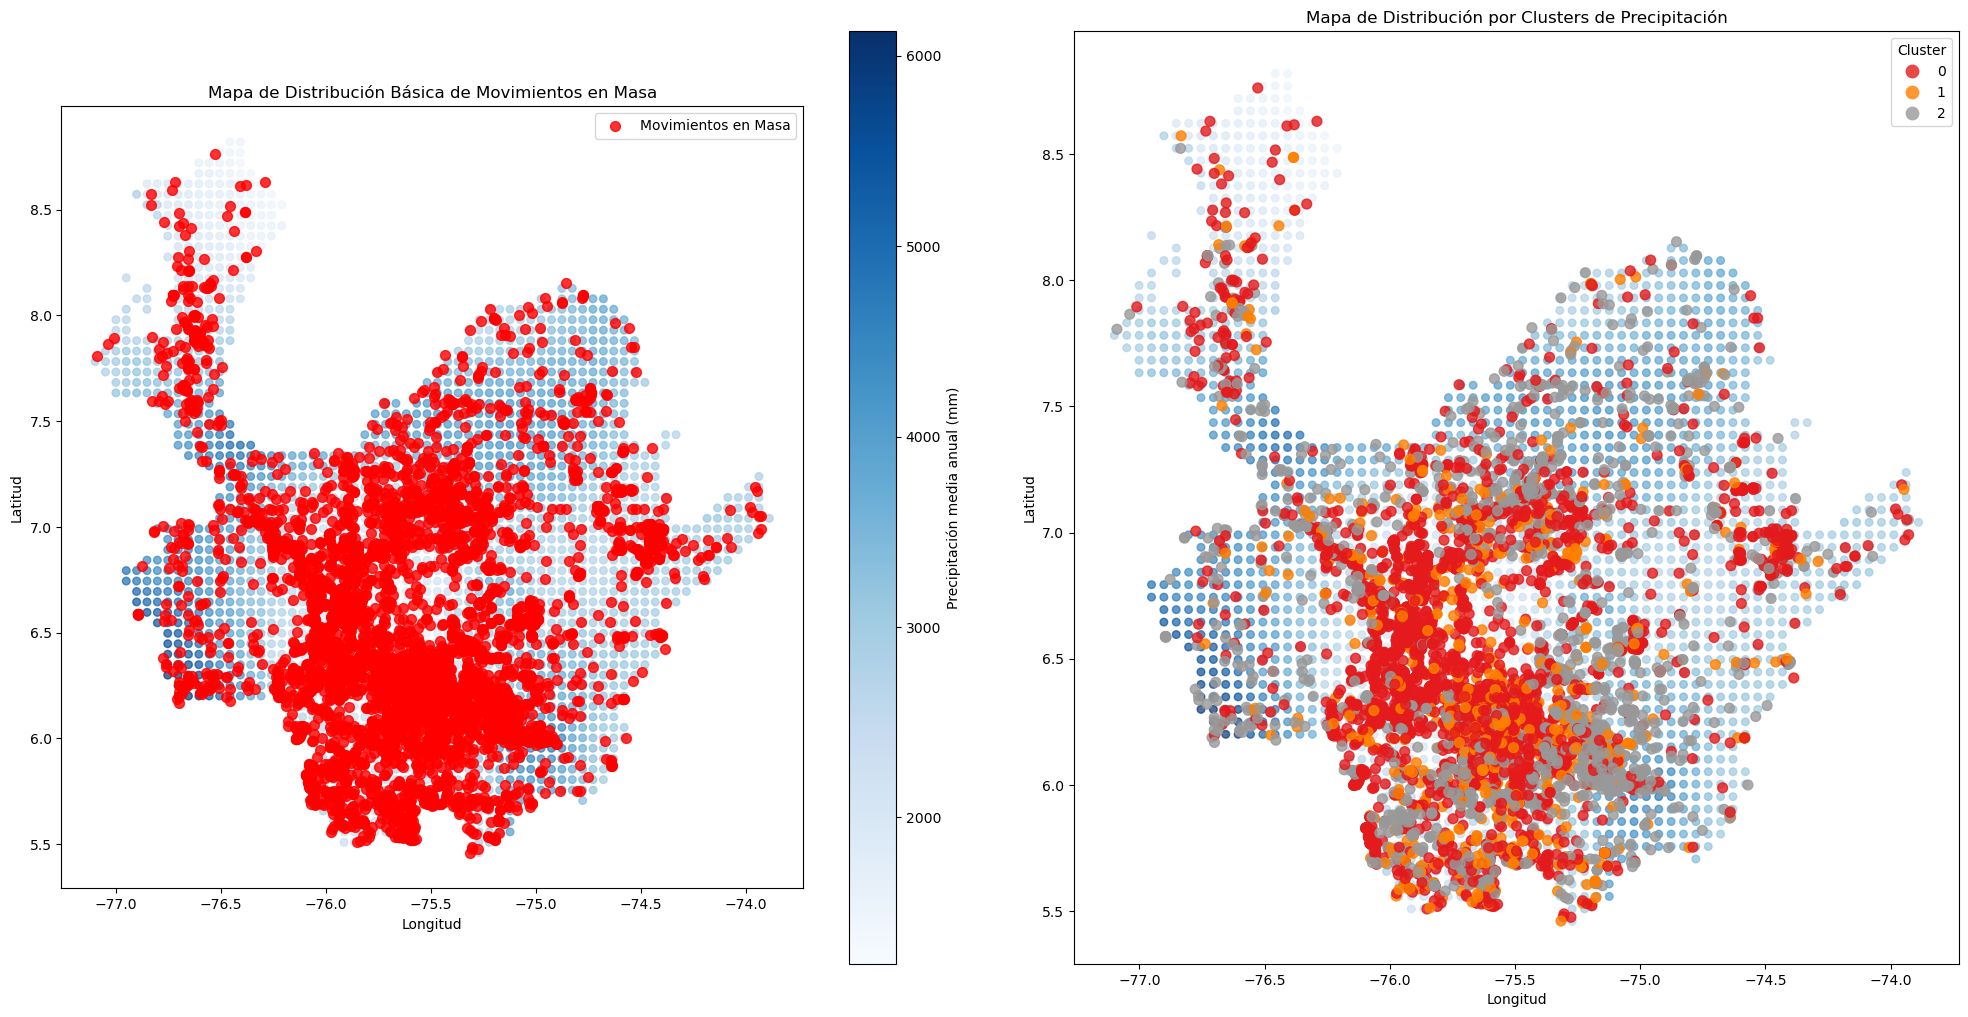


Generando matrices de correlación...


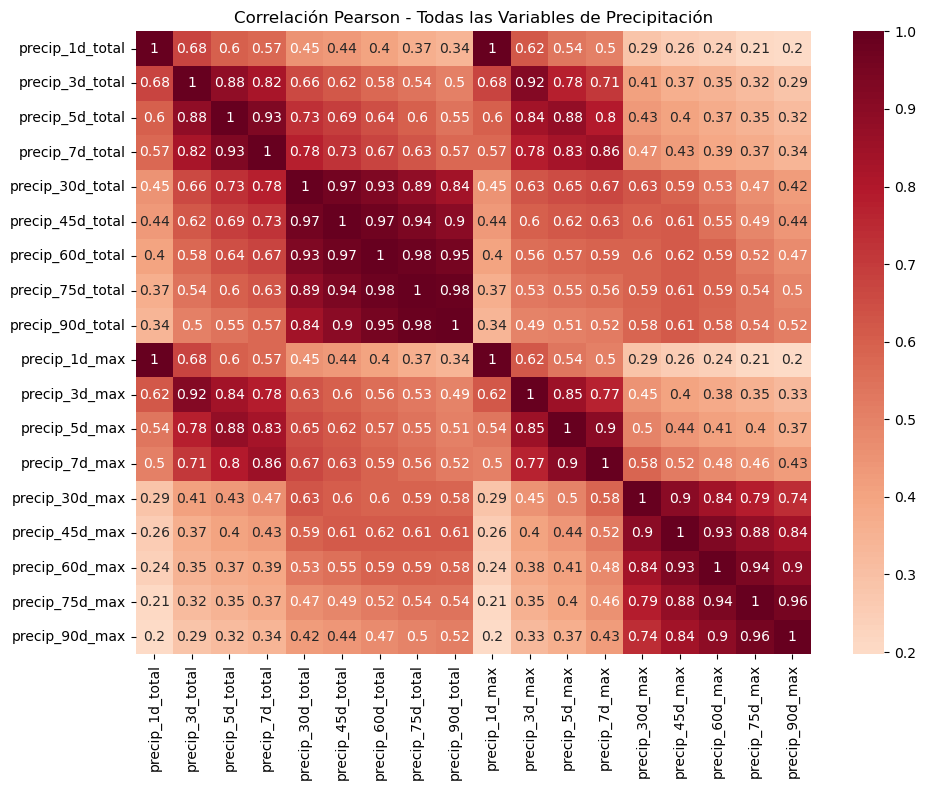

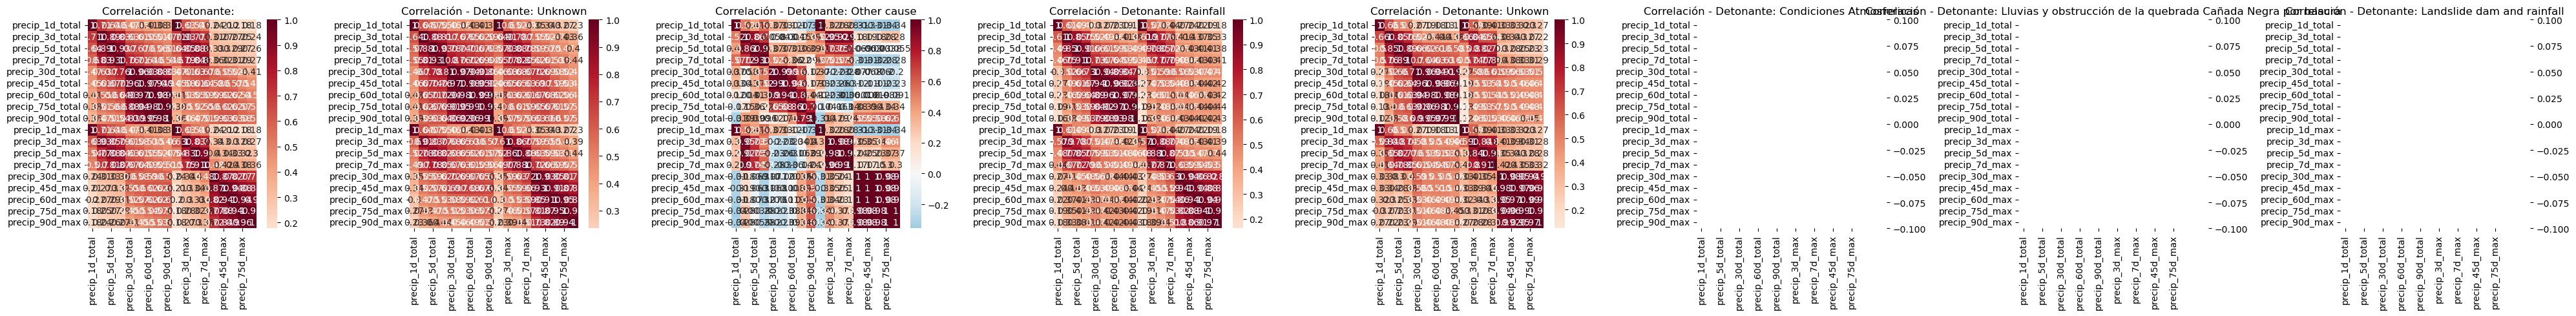


Generando análisis de detonantes...


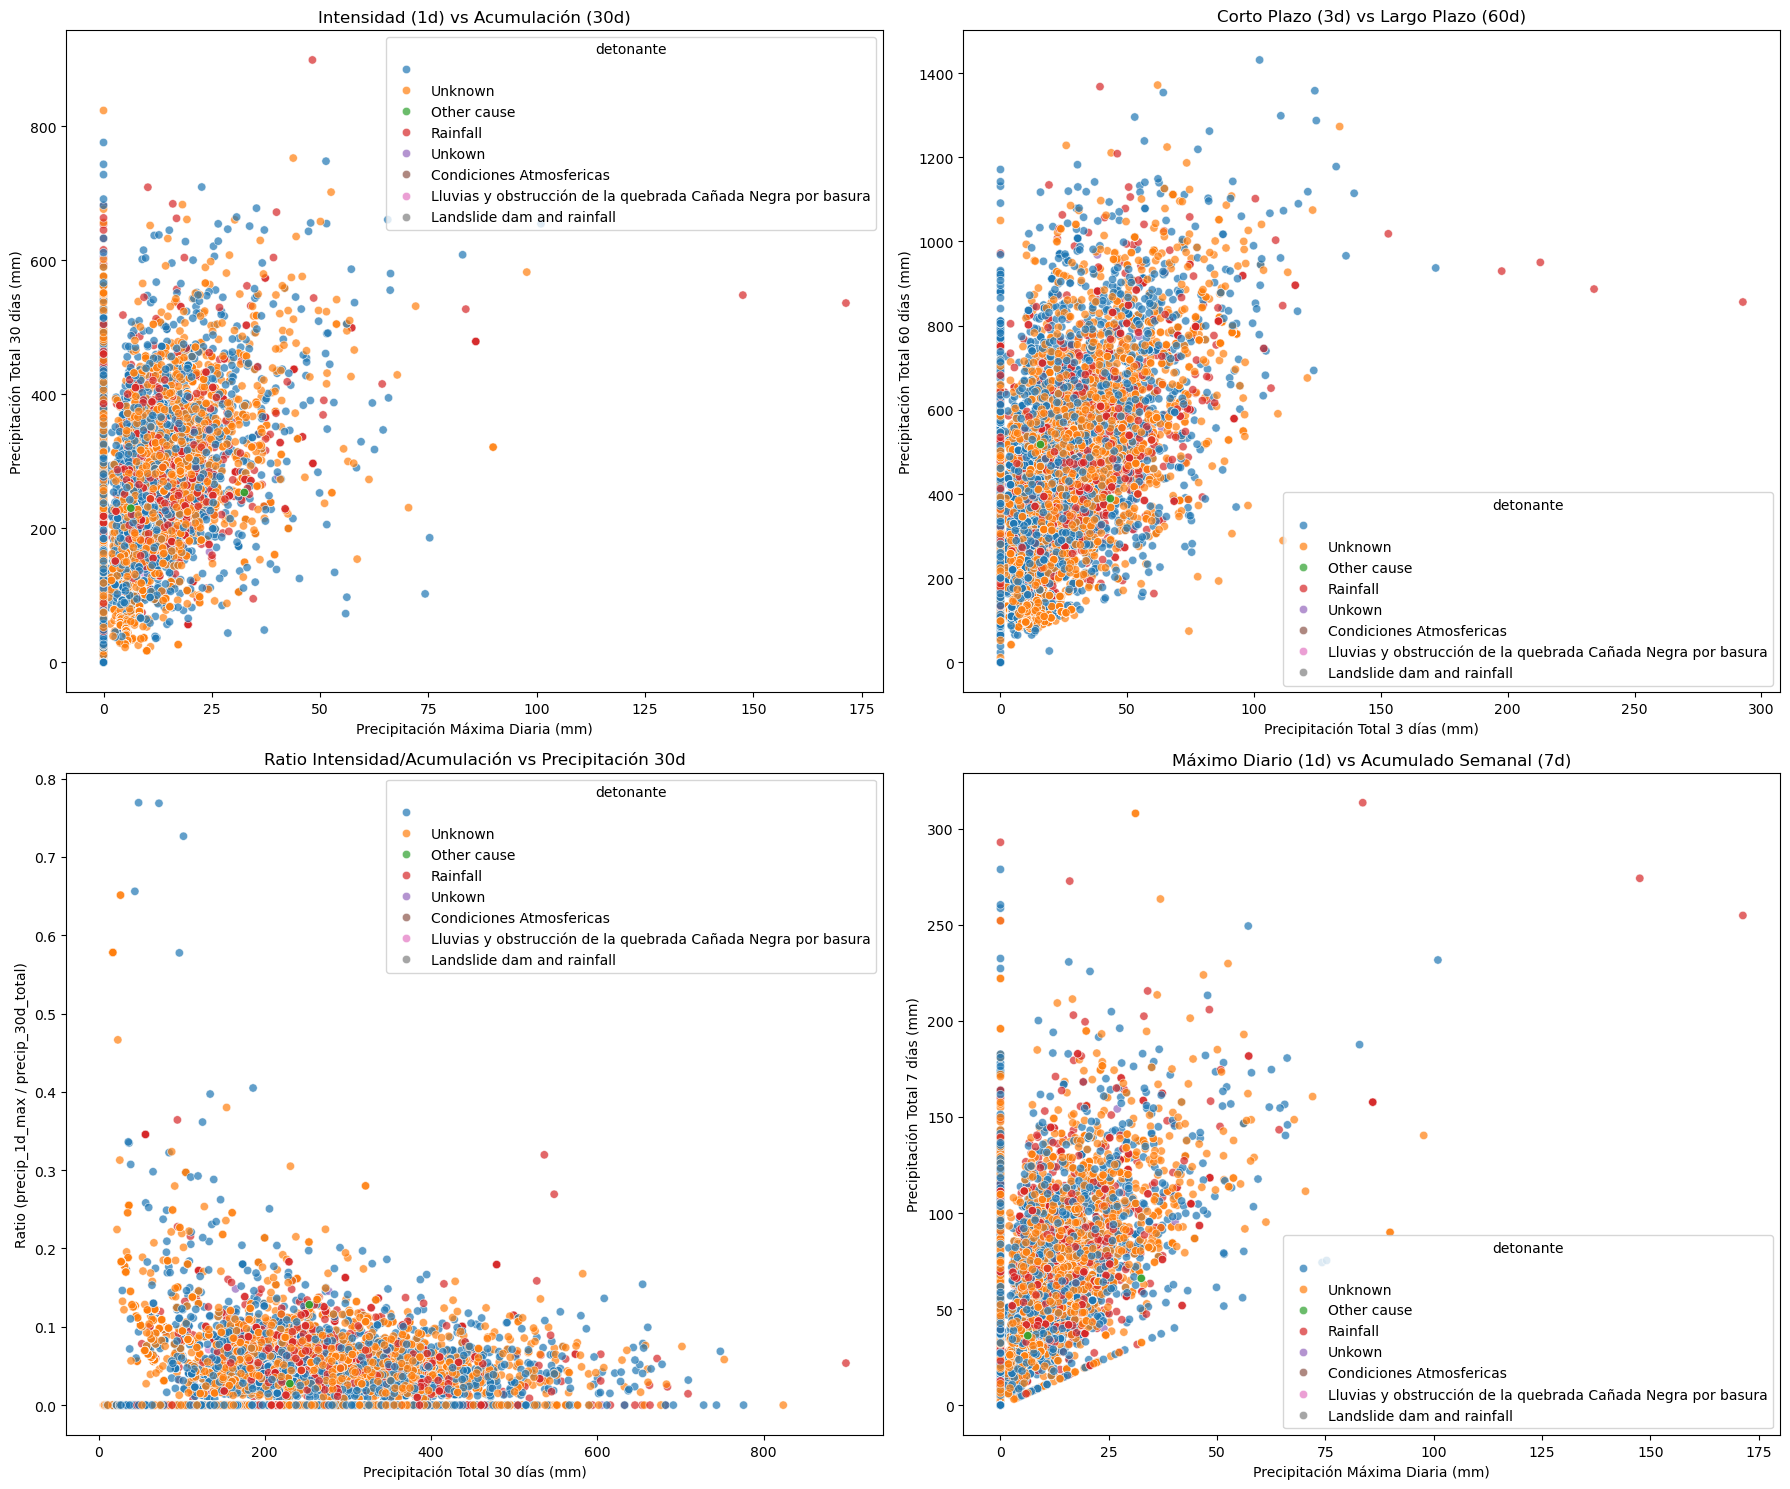


Generando distribuciones por ventana temporal...


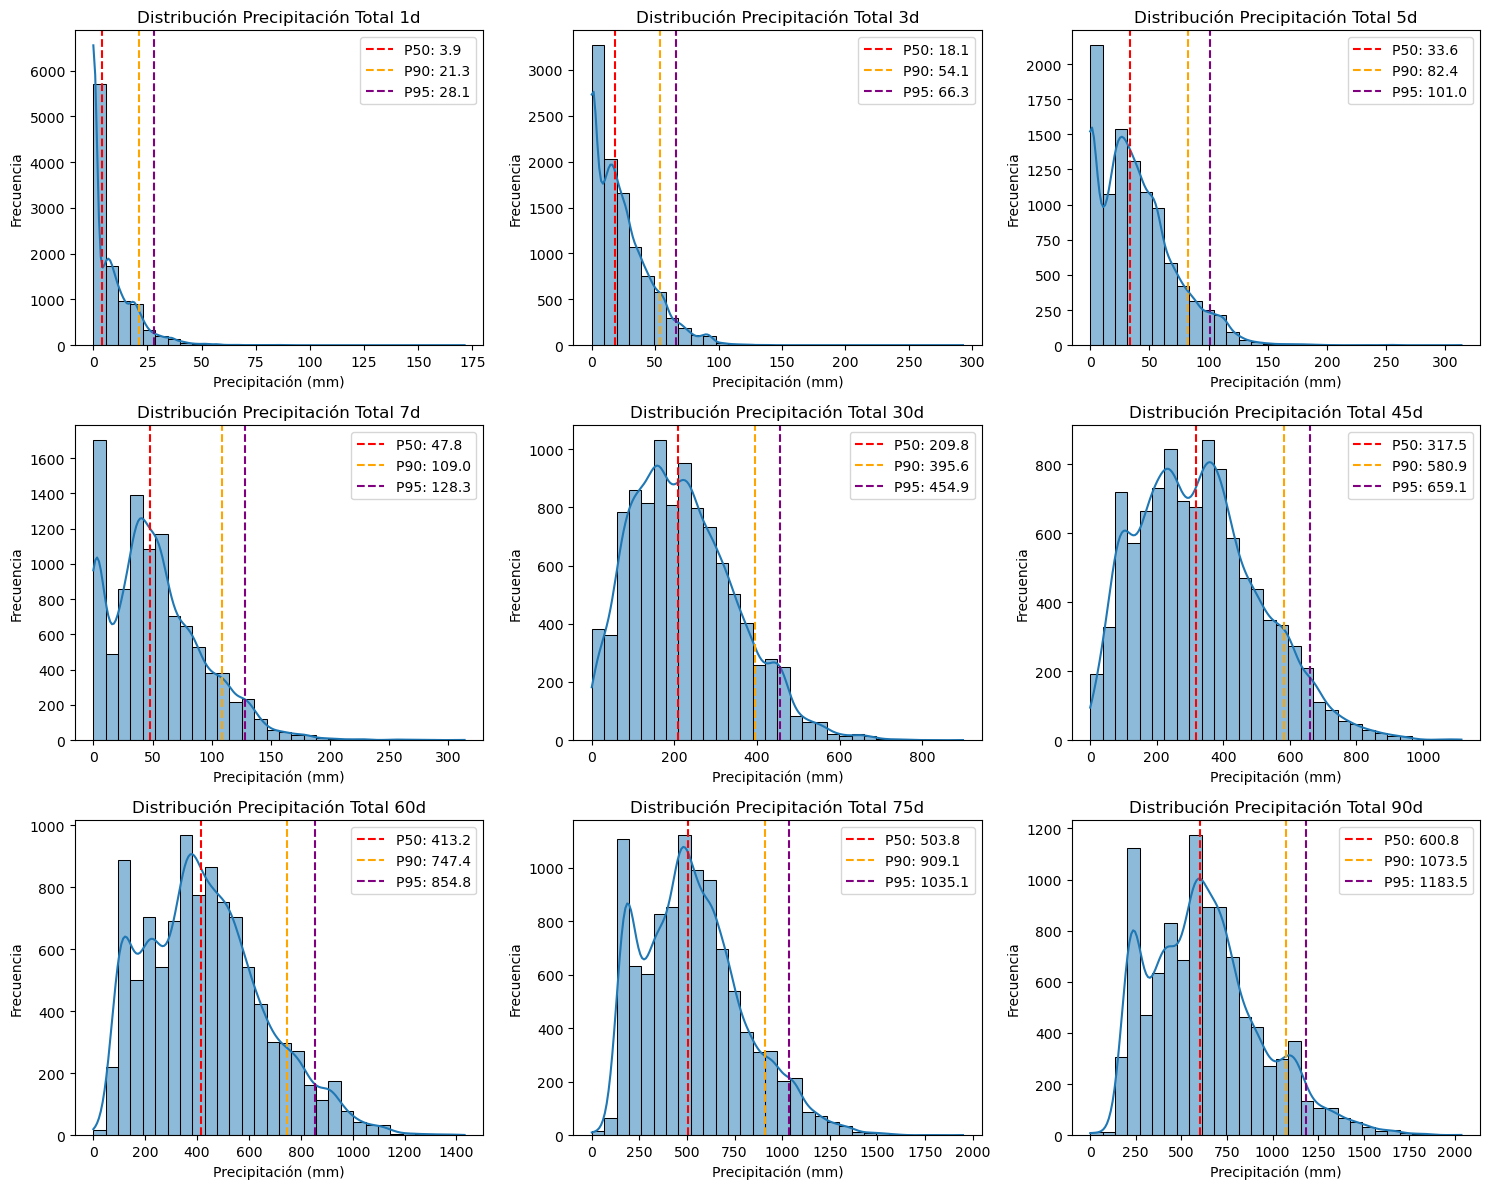


Generando análisis temporales...


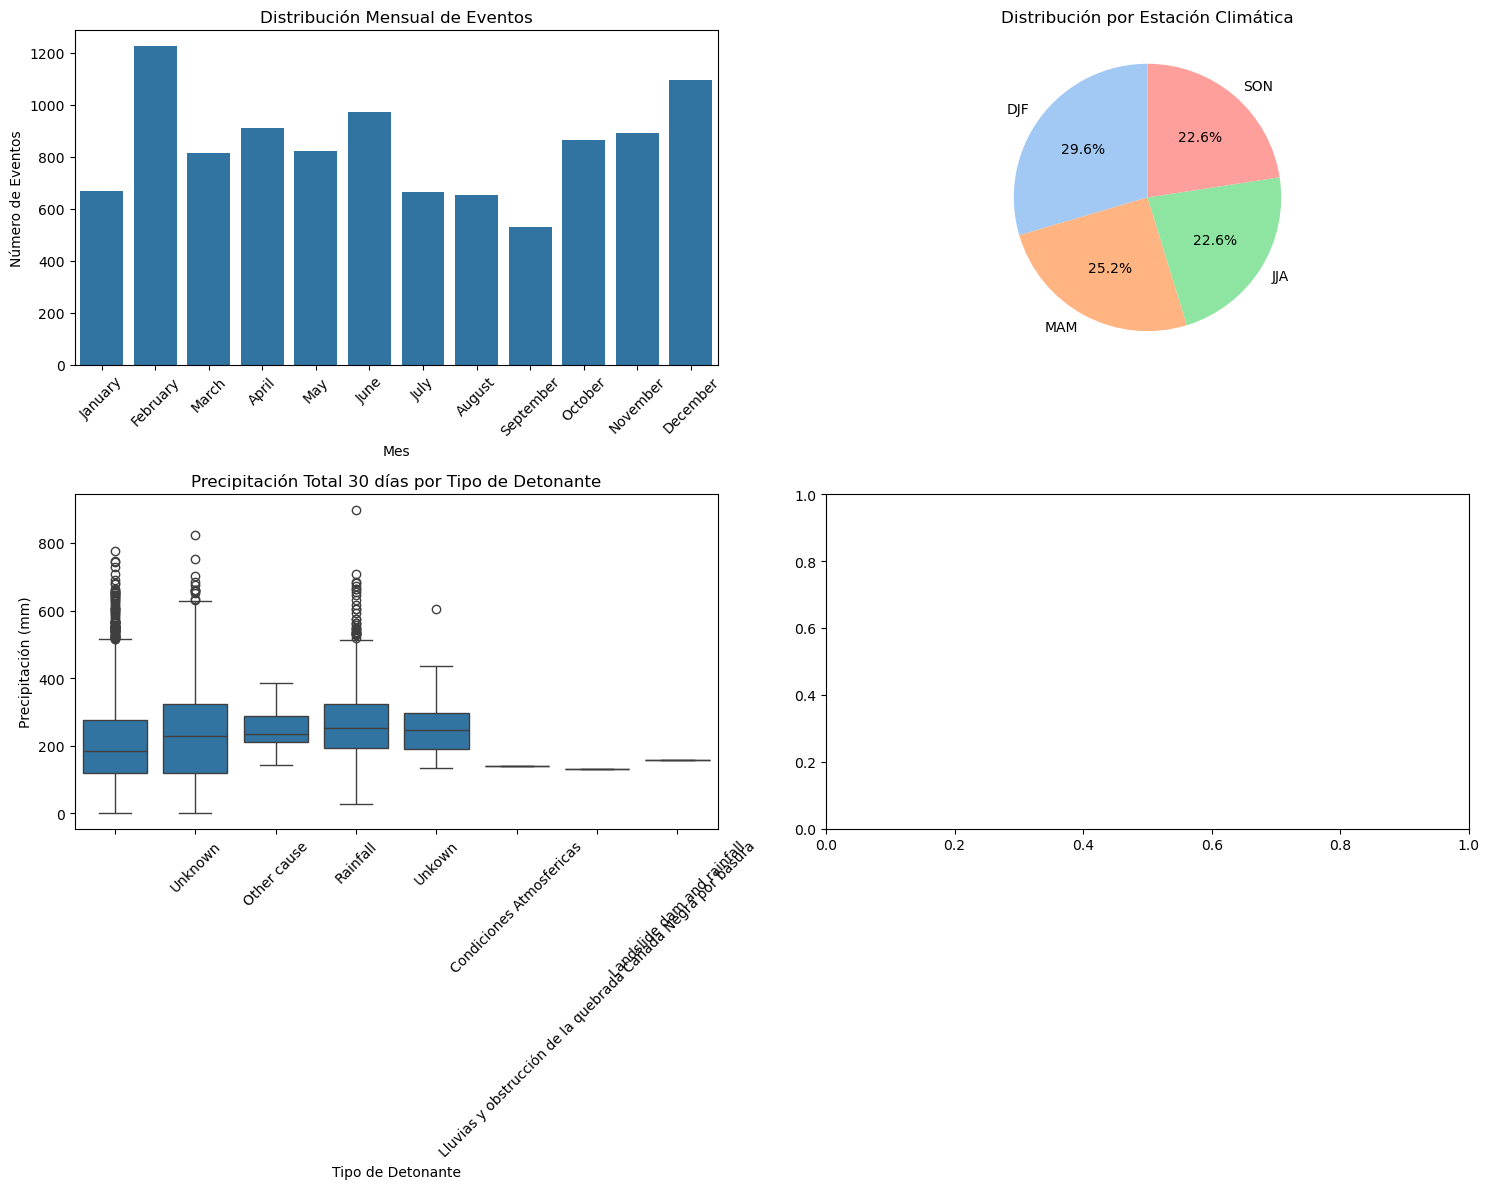


Generando caracterización de clusters...


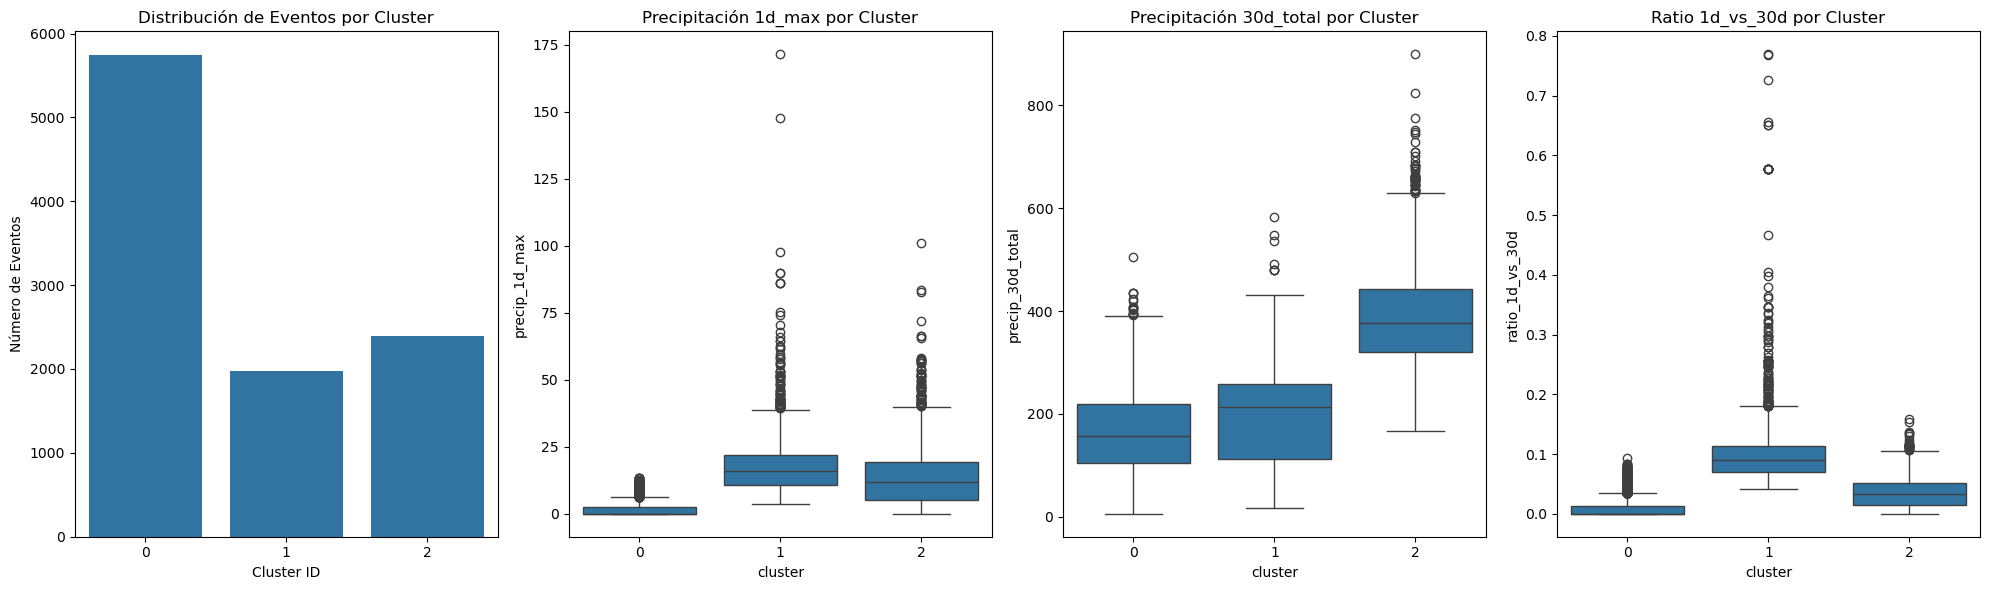


Generando análisis de umbrales críticos...


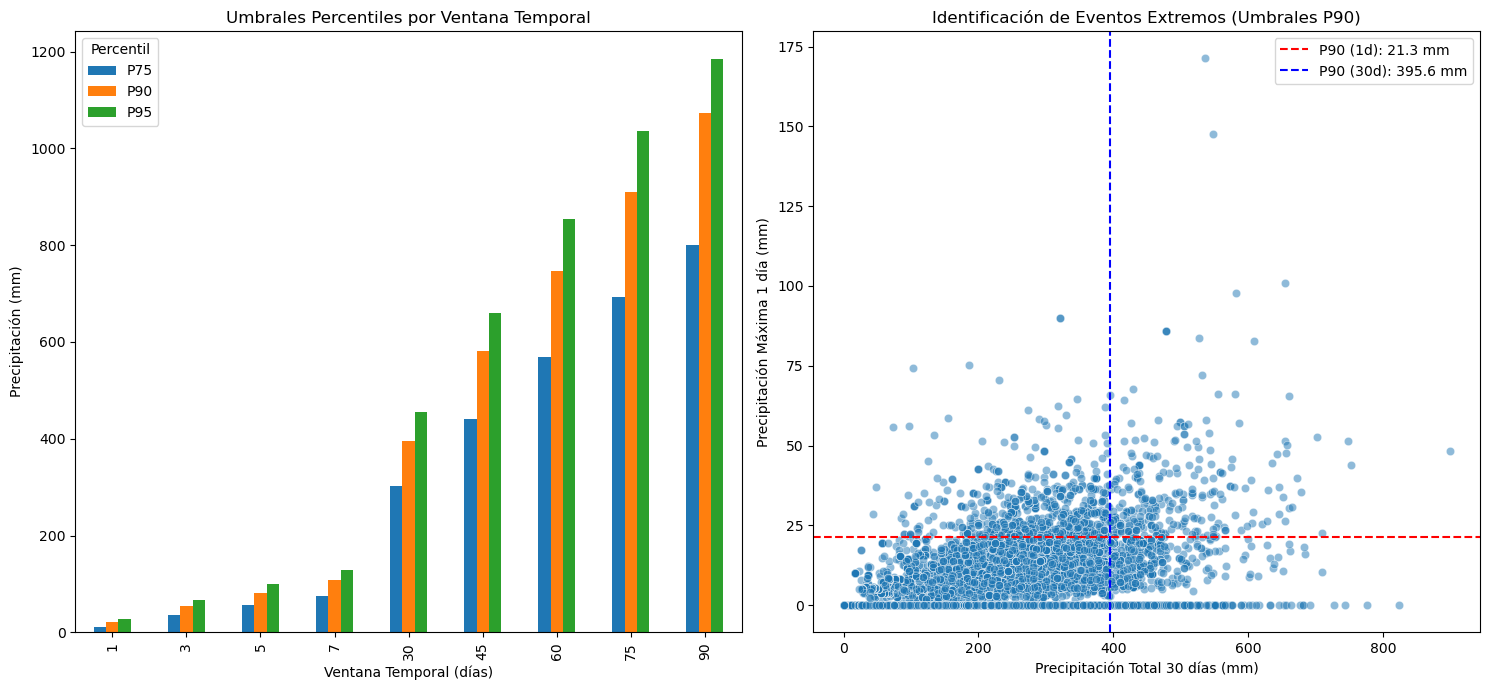


RESUMEN ESTADÍSTICO Y ANÁLISIS CLUSTER

Precipitación 1 días:
count    10115.000000
mean         7.627295
std         10.691909
min          0.000000
25%          0.000000
50%          3.886975
75%         12.111610
max        171.376400
Name: precip_1d_total, dtype: float64

Precipitación 3 días:
count    10115.000000
mean        23.194922
std         22.304082
min          0.000000
25%          5.118802
50%         18.122770
75%         35.147500
max        292.690890
Name: precip_3d_total, dtype: float64

Precipitación 5 días:
count    10115.000000
mean        38.710828
std         31.685394
min          0.000000
25%         15.448448
50%         33.574457
75%         55.714794
max        313.597382
Name: precip_5d_total, dtype: float64

Precipitación 7 días:
count    10115.000000
mean        53.312930
std         39.971971
min          0.000000
25%         24.996309
50%         47.838959
75%         76.059226
max        313.597382
Name: precip_7d_total, dtype: float64

Precipitaci

In [3]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr, spearmanr
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import json
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 1. CARGAR Y PROCESAR DATOS CHIRPS
# ============================================================================

def cargar_datos_chirps(ruta_csv):
    """Carga y procesa los datos CHIRPS"""
    print("Cargando datos CHIRPS...")
    df = pd.read_csv(ruta_csv)
    
    # Extraer coordenadas desde el campo .geo
    df[".geo"] = df[".geo"].astype(str)
    df[["lon", "lat"]] = df[".geo"].apply(lambda x: pd.Series(json.loads(x)["coordinates"]))
    
    # Convertir fecha a datetime
    df["fecha"] = pd.to_datetime(df["fecha"])
    
    # Crear identificador único de píxel
    df['pixel_id'] = df.groupby(['lat', 'lon']).ngroup()
    
    print(f"Datos CHIRPS cargados: {len(df)} registros, {df['pixel_id'].nunique()} píxeles únicos")
    print(f"Rango temporal: {df['fecha'].min()} a {df['fecha'].max()}")
    
    return df

def crear_grilla_pixeles(df_chirps):
    """Crear DataFrame con información de píxeles únicos"""
    pixeles = df_chirps[['pixel_id', 'lat', 'lon']].drop_duplicates().reset_index(drop=True)
    
    # Crear GeoDataFrame de píxeles
    geometry = [Point(xy) for xy in zip(pixeles.lon, pixeles.lat)]
    gdf_pixeles = gpd.GeoDataFrame(pixeles, geometry=geometry, crs="EPSG:4326")
    
    return pixeles, gdf_pixeles

# ============================================================================
# 2. CARGAR Y PROCESAR INVENTARIO DE MM
# ============================================================================

def cargar_inventario_mm(ruta_inv):
    """Carga y procesa el inventario de movimientos en masa"""
    print("\nCargando inventario de MM...")
    df_inv = pd.read_csv(ruta_inv)
    
    # Intentar múltiples formatos de fecha y corregir año
    df_inv['fecha_evento'] = None
    
    # Usar una función para manejar múltiples formatos y el año
    def parse_date(date_str):
        if pd.isna(date_str):
            return pd.NaT
        try:
            date_obj = pd.to_datetime(date_str, format='%Y-%m-%d')
            if date_obj.year == 2025: # Asumimos que los datos son de 2024
                date_obj = date_obj.replace(year=2024)
            return date_obj
        except ValueError:
            try:
                date_obj = pd.to_datetime(date_str, format='%d-%m-%y')
                if date_obj.year == 24: # Asumimos que es 2024
                    date_obj = date_obj.replace(year=2024)
                return date_obj
            except ValueError:
                return pd.NaT

    if 'Fecha_Limpia' in df_inv.columns:
        df_inv['fecha_evento'] = df_inv['Fecha_Limpia'].astype(str).apply(parse_date)
    
    if 'Fecha' in df_inv.columns:
        mask_null = df_inv['fecha_evento'].isnull()
        df_inv.loc[mask_null, 'fecha_evento'] = df_inv.loc[mask_null, 'Fecha'].astype(str).apply(parse_date)

    # Limpiar coordenadas
    df_inv['lat'] = pd.to_numeric(df_inv['LAT'], errors='coerce')
    df_inv['lon'] = pd.to_numeric(df_inv['LONG'], errors='coerce')
    
    # Filtrar datos válidos
    mask_validos = (df_inv['lat'].notna() & 
                    df_inv['lon'].notna() & 
                    df_inv['fecha_evento'].notna())
    
    df_inv = df_inv[mask_validos].reset_index(drop=True)
    
    # Rellenar valores faltantes
    df_inv['Tipo'] = df_inv['Tipo'].fillna('Unknown')
    df_inv['Detonante'] = df_inv['Detonante'].fillna('Unknown')
    
    print(f"MM procesados: {len(df_inv)} eventos válidos")
    if len(df_inv) > 0:
        print(f"Rango temporal MM: {df_inv['fecha_evento'].min()} a {df_inv['fecha_evento'].max()}")
        print("Tipos de MM:", df_inv['Tipo'].value_counts().to_dict())
        print("Detonantes:", df_inv['Detonante'].value_counts().to_dict())
    
    return df_inv

# ============================================================================
# 3. ASIGNACIÓN DE PÍXELES MÁS CERCANOS
# ============================================================================

def asignar_pixeles_mm(df_inv, pixeles):
    """Asigna a cada MM el píxel CHIRPS más cercano"""
    print("\nAsignando píxeles más cercanos a los MM...")
    
    coords_mm = df_inv[['lat', 'lon']].values
    coords_pixeles = pixeles[['lat', 'lon']].values
    
    # Calcular distancias y encontrar píxel más cercano
    distancias = cdist(coords_mm, coords_pixeles, metric='euclidean')
    indices_cercanos = np.argmin(distancias, axis=1)
    distancias_min = np.min(distancias, axis=1)
    
    # Asignar píxel más cercano
    df_inv['pixel_id'] = pixeles.iloc[indices_cercanos]['pixel_id'].values
    df_inv['pixel_lat'] = pixeles.iloc[indices_cercanos]['lat'].values
    df_inv['pixel_lon'] = pixeles.iloc[indices_cercanos]['lon'].values
    df_inv['distancia_pixel'] = distancias_min
    
    print(f"Distancia promedio al píxel más cercano: {distancias_min.mean():.4f}° ({distancias_min.mean()*111:.1f} km)")
    
    return df_inv

# ============================================================================
# 4. CÁLCULO DE PRECIPITACIÓN EN VENTANAS TEMPORALES MEJORADO
# ============================================================================

def calcular_precipitacion_ventanas(df_inv, df_chirps, ventanas=[1, 3, 5, 7, 30, 45, 60, 75, 90]):
    """Calcula precipitación acumulada en diferentes ventanas temporales"""
    print(f"\nCalculando precipitación para ventanas: {ventanas} días...")
    
    resultados = []
    df_chirps_grouped = df_chirps.groupby('pixel_id')
    
    for idx, row in df_inv.iterrows():
        if idx % 100 == 0:
            print(f"Procesando MM {idx+1}/{len(df_inv)}")
        
        pixel_id = row['pixel_id']
        fecha_evento = row['fecha_evento']
        
        # Filtrar datos del píxel específico
        try:
            datos_pixel = df_chirps_grouped.get_group(pixel_id).copy()
        except KeyError:
            continue
        
        resultado = {
            'mm_id': idx,
            'pixel_id': pixel_id,
            'fecha_evento': fecha_evento,
            'lat_mm': row['lat'],
            'lon_mm': row['lon'],
            'tipo': row.get('Tipo', 'Unknown'),
            'detonante': row.get('Detonante', 'Unknown')
        }
        
        # Calcular precipitación para cada ventana
        for ventana in ventanas:
            fecha_inicio = fecha_evento - pd.Timedelta(days=ventana-1)
            mask = (datos_pixel['fecha'] >= fecha_inicio) & (datos_pixel['fecha'] <= fecha_evento)
            datos_ventana = datos_pixel[mask]
            
            if len(datos_ventana) > 0:
                precip_total = datos_ventana['precipitacion'].sum()
                precip_max_dia = datos_ventana['precipitacion'].max()
                precip_min_dia = datos_ventana['precipitacion'].min()
                precip_promedio = datos_ventana['precipitacion'].mean()
                dias_con_lluvia = (datos_ventana['precipitacion'] > 0).sum()
                dias_lluvia_intensa = (datos_ventana['precipitacion'] >= 20).sum() # Umbral de 20mm/día
            else:
                precip_total, precip_max_dia, precip_min_dia, precip_promedio = np.nan, np.nan, np.nan, np.nan
                dias_con_lluvia, dias_lluvia_intensa = 0, 0
                
            resultado[f'precip_{ventana}d_total'] = precip_total
            resultado[f'precip_{ventana}d_max'] = precip_max_dia
            resultado[f'precip_{ventana}d_min'] = precip_min_dia
            resultado[f'precip_{ventana}d_promedio'] = precip_promedio
            resultado[f'dias_lluvia_{ventana}d'] = dias_con_lluvia
            resultado[f'dias_lluvia_intensa_{ventana}d'] = dias_lluvia_intensa
            
        # Calcular rachas secas y ratios
        # Racha seca máxima en los 30 días previos
        fecha_inicio_30d_previos = fecha_evento - pd.Timedelta(days=30)
        mask_30d_previos = (datos_pixel['fecha'] >= fecha_inicio_30d_previos) & (datos_pixel['fecha'] < fecha_evento)
        datos_30d_previos = datos_pixel[mask_30d_previos]
        
        if not datos_30d_previos.empty:
            zeros = (datos_30d_previos['precipitacion'] == 0).astype(int)
            if zeros.empty:
                racha_seca = 0
            else:
                # Calcular racha más larga de ceros
                zeros_shifted = zeros.shift(1).fillna(0)
                cum_zeros = zeros.groupby((zeros != zeros_shifted).cumsum()).cumsum()
                racha_seca = cum_zeros.max() if not cum_zeros.empty else 0
        else:
            racha_seca = 0

        resultado['racha_seca_max_30d'] = racha_seca
        
        # Ratio intensidad vs acumulado
        if 'precip_30d_total' in resultado and resultado['precip_30d_total'] > 0:
            resultado['ratio_1d_vs_30d'] = resultado.get('precip_1d_max', 0) / resultado.get('precip_30d_total', 1)
        else:
            resultado['ratio_1d_vs_30d'] = np.nan
        
        resultados.append(resultado)
    
    df_resultados = pd.DataFrame(resultados)
    print(f"Calculada precipitación para {len(df_resultados)} MM")
    
    return df_resultados

# ============================================================================
# 5. CLUSTERING Y CARACTERIZACIÓN
# ============================================================================

def realizar_clustering(df_resultados):
    """Agrupa eventos por patrones de precipitación usando K-means"""
    print("\nRealizando clustering de eventos...")
    
    # Seleccionar variables para el clustering
    cols_cluster = ['precip_1d_max', 'precip_7d_total', 'precip_30d_total', 'ratio_1d_vs_30d']
    df_cluster = df_resultados.dropna(subset=cols_cluster).copy()
    
    if len(df_cluster) < 2:
        print("No hay suficientes datos para el clustering.")
        return None
    
    # Estandarizar las variables
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df_cluster[cols_cluster])
    
    # Usar un número fijo de clusters (puedes optimizarlo con el método del codo)
    n_clusters = 3
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df_cluster['cluster'] = kmeans.fit_predict(scaled_features)
    
    # Unir resultados al dataframe principal
    df_resultados = pd.merge(df_resultados, df_cluster[['mm_id', 'cluster']], on='mm_id', how='left')
    df_resultados['cluster'] = df_resultados['cluster'].fillna(-1).astype(int) # -1 para los que no se pudieron clusterizar
    
    print(f"Clustering completado. Clusters creados: {df_resultados['cluster'].unique()}")
    print("Conteo por cluster:")
    print(df_resultados['cluster'].value_counts())
    
    return df_resultados

# ============================================================================
# 6. VISUALIZACIONES MEJORADAS (AGRUPADAS POR CATEGORÍA)
# ============================================================================

def crear_visualizaciones_mapas(df_resultados, df_chirps, gdf_pixeles):
    """Genera mapas geospaciales de precipitación y MM con clustering."""
    print("\nGenerando mapas geospaciales...")
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # Calcular precipitación media anual por píxel
    precip_anual = df_chirps.groupby(['pixel_id', 'lat', 'lon', df_chirps['fecha'].dt.year])['precipitacion'].sum().reset_index()
    precip_media = precip_anual.groupby(['pixel_id', 'lat', 'lon'])['precipitacion'].mean().reset_index()
    
    geometry_precip = [Point(xy) for xy in zip(precip_media.lon, precip_media.lat)]
    gdf_precip = gpd.GeoDataFrame(precip_media, geometry=geometry_precip, crs="EPSG:4326")
    
    # Gráfica 1.1: Mapa de Distribución Básica
    ax1 = axes[0]
    gdf_precip.plot(column='precipitacion', cmap='Blues', markersize=30, alpha=0.7, 
                     legend=True, ax=ax1, legend_kwds={'label': 'Precipitación media anual (mm)'})
    
    if len(df_resultados) > 0:
        geometry_mm = [Point(xy) for xy in zip(df_resultados.lon_mm, df_resultados.lat_mm)]
        gdf_mm = gpd.GeoDataFrame(df_resultados, geometry=geometry_mm, crs="EPSG:4326")
        gdf_mm.plot(color='red', markersize=50, ax=ax1, alpha=0.8, label='Movimientos en Masa')
    
    ax1.set_title('Mapa de Distribución Básica de Movimientos en Masa')
    ax1.set_xlabel('Longitud')
    ax1.set_ylabel('Latitud')
    ax1.legend()
    
    # Gráfica 1.2: Mapa por Clusters de Precipitación
    ax2 = axes[1]
    gdf_precip.plot(column='precipitacion', cmap='Blues', markersize=30, alpha=0.7, ax=ax2)
    
    if 'cluster' in df_resultados.columns and len(df_resultados[df_resultados['cluster'] != -1]) > 0:
        gdf_mm_cluster = gdf_mm[gdf_mm['cluster'] != -1].copy()
        gdf_mm_cluster.plot(column='cluster', categorical=True, markersize=50, ax=ax2, alpha=0.8, 
                             legend=True, cmap='Set1', legend_kwds={'title': 'Cluster'})
    
    ax2.set_title('Mapa de Distribución por Clusters de Precipitación')
    ax2.set_xlabel('Longitud')
    ax2.set_ylabel('Latitud')
    
    plt.tight_layout()
    plt.savefig('mapas_mm_clustering.png', dpi=300, bbox_inches='tight')
    plt.show()

def crear_visualizaciones_correlaciones(df_resultados, ventanas):
    """Genera matrices de correlación segmentadas."""
    print("\nGenerando matrices de correlación...")
    
    # Preparar datos
    variables_precip = [f'precip_{v}d_total' for v in ventanas] + [f'precip_{v}d_max' for v in ventanas]
    df_corr = df_resultados[variables_precip].dropna()
    
    if df_corr.empty:
        print("No hay suficientes datos para matrices de correlación.")
        return
        
    # Correlación General
    fig, ax = plt.subplots(figsize=(10, 8))
    corr_pearson_general = df_corr.corr(method='pearson')
    sns.heatmap(corr_pearson_general, annot=True, cmap='RdBu_r', center=0, ax=ax)
    ax.set_title('Correlación Pearson - Todas las Variables de Precipitación')
    plt.tight_layout()
    plt.savefig('correlaciones_generales.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Correlaciones por tipo de detonante
    detonantes = df_resultados['detonante'].unique()
    if len(detonantes) > 1:
        fig, axes = plt.subplots(1, len(detonantes), figsize=(5 * len(detonantes), 5))
        if len(detonantes) == 1:
            axes = [axes]
        
        for i, det in enumerate(detonantes):
            df_det = df_resultados[df_resultados['detonante'] == det].dropna(subset=variables_precip)
            if not df_det.empty:
                corr = df_det[variables_precip].corr(method='pearson')
                sns.heatmap(corr, annot=True, cmap='RdBu_r', center=0, ax=axes[i])
                axes[i].set_title(f'Correlación - Detonante: {det}')
        plt.tight_layout()
        plt.savefig('correlaciones_por_detonante.png', dpi=300, bbox_inches='tight')
        plt.show()

def crear_visualizaciones_detonantes(df_resultados):
    """Genera scatter plots para analizar detonantes intensos vs acumulados."""
    print("\nGenerando análisis de detonantes...")
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 15))
    axes = axes.ravel()
    
    # Scatter plot: 1d vs 30d
    sns.scatterplot(data=df_resultados, x='precip_1d_max', y='precip_30d_total', hue='detonante', ax=axes[0], alpha=0.7)
    axes[0].set_title('Intensidad (1d) vs Acumulación (30d)')
    axes[0].set_xlabel('Precipitación Máxima Diaria (mm)')
    axes[0].set_ylabel('Precipitación Total 30 días (mm)')
    
    # Scatter plot: 3d vs 60d
    sns.scatterplot(data=df_resultados, x='precip_3d_total', y='precip_60d_total', hue='detonante', ax=axes[1], alpha=0.7)
    axes[1].set_title('Corto Plazo (3d) vs Largo Plazo (60d)')
    axes[1].set_xlabel('Precipitación Total 3 días (mm)')
    axes[1].set_ylabel('Precipitación Total 60 días (mm)')
    
    # Scatter plot: Ratio vs 30d
    sns.scatterplot(data=df_resultados, x='precip_30d_total', y='ratio_1d_vs_30d', hue='detonante', ax=axes[2], alpha=0.7)
    axes[2].set_title('Ratio Intensidad/Acumulación vs Precipitación 30d')
    axes[2].set_xlabel('Precipitación Total 30 días (mm)')
    axes[2].set_ylabel('Ratio (precip_1d_max / precip_30d_total)')
    
    # Scatter plot: Max 1d vs 7d
    sns.scatterplot(data=df_resultados, x='precip_1d_max', y='precip_7d_total', hue='detonante', ax=axes[3], alpha=0.7)
    axes[3].set_title('Máximo Diario (1d) vs Acumulado Semanal (7d)')
    axes[3].set_xlabel('Precipitación Máxima Diaria (mm)')
    axes[3].set_ylabel('Precipitación Total 7 días (mm)')

    plt.tight_layout()
    plt.savefig('analisis_detonantes_intenso_vs_acumulado.png', dpi=300, bbox_inches='tight')
    plt.show()

def crear_visualizaciones_distribuciones(df_resultados, ventanas):
    """Genera histogramas de precipitación por ventana temporal."""
    print("\nGenerando distribuciones por ventana temporal...")
    
    num_ventanas = len(ventanas)
    cols = 3
    rows = int(np.ceil(num_ventanas / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.ravel()
    
    for i, ventana in enumerate(ventanas):
        col_total = f'precip_{ventana}d_total'
        if col_total in df_resultados.columns:
            data = df_resultados[col_total].dropna()
            if not data.empty:
                sns.histplot(data, bins=30, kde=True, ax=axes[i])
                axes[i].set_title(f'Distribución Precipitación Total {ventana}d')
                axes[i].set_xlabel('Precipitación (mm)')
                axes[i].set_ylabel('Frecuencia')
                
                # Añadir líneas de percentiles
                p50, p90, p95 = np.percentile(data, [50, 90, 95])
                axes[i].axvline(p50, color='red', linestyle='--', label=f'P50: {p50:.1f}')
                axes[i].axvline(p90, color='orange', linestyle='--', label=f'P90: {p90:.1f}')
                axes[i].axvline(p95, color='purple', linestyle='--', label=f'P95: {p95:.1f}')
                axes[i].legend()

    plt.tight_layout()
    plt.savefig('distribuciones_por_ventana_mejorado.png', dpi=300, bbox_inches='tight')
    plt.show()

def crear_visualizaciones_temporales(df_resultados):
    """Genera análisis de estacionalidad y box plots por detonante."""
    print("\nGenerando análisis temporales...")
    
    df_temp = df_resultados.copy()
    df_temp['mes'] = df_temp['fecha_evento'].dt.month
    df_temp['estacion'] = df_temp['mes'].apply(lambda m: 'DJF' if m in [12, 1, 2] else 'MAM' if m in [3, 4, 5] else 'JJA' if m in [6, 7, 8] else 'SON')
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Distribución Mensual
    df_temp['mes_nombre'] = df_temp['fecha_evento'].dt.strftime('%B')
    meses_orden = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    sns.countplot(x='mes_nombre', data=df_temp, ax=axes[0, 0], order=meses_orden)
    axes[0, 0].set_title('Distribución Mensual de Eventos')
    axes[0, 0].set_xlabel('Mes')
    axes[0, 0].set_ylabel('Número de Eventos')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Distribución por Estación
    estacion_counts = df_temp['estacion'].value_counts()
    axes[0, 1].pie(estacion_counts, labels=estacion_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
    axes[0, 1].set_title('Distribución por Estación Climática')
    
    # Box Plot por Detonante (precip_30d_total)
    sns.boxplot(x='detonante', y='precip_30d_total', data=df_temp, ax=axes[1, 0])
    axes[1, 0].set_title('Precipitación Total 30 días por Tipo de Detonante')
    axes[1, 0].set_xlabel('Tipo de Detonante')
    axes[1, 0].set_ylabel('Precipitación (mm)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('analisis_temporal_detallado.png', dpi=300, bbox_inches='tight')
    plt.show()

def crear_visualizaciones_clustering(df_resultados):
    """Genera visualizaciones para caracterizar los clusters."""
    print("\nGenerando caracterización de clusters...")
    
    df_cluster = df_resultados[df_resultados['cluster'] != -1].copy()
    if df_cluster.empty:
        print("No hay datos para caracterizar clusters.")
        return
        
    fig, axes = plt.subplots(1, 4, figsize=(20, 6))
    
    # Distribución de Clusters
    sns.countplot(x='cluster', data=df_cluster, ax=axes[0])
    axes[0].set_title('Distribución de Eventos por Cluster')
    axes[0].set_xlabel('Cluster ID')
    axes[0].set_ylabel('Número de Eventos')
    
    # Box plots para caracterizar los clusters
    sns.boxplot(x='cluster', y='precip_1d_max', data=df_cluster, ax=axes[1])
    axes[1].set_title('Precipitación 1d_max por Cluster')
    
    sns.boxplot(x='cluster', y='precip_30d_total', data=df_cluster, ax=axes[2])
    axes[2].set_title('Precipitación 30d_total por Cluster')
    
    sns.boxplot(x='cluster', y='ratio_1d_vs_30d', data=df_cluster, ax=axes[3])
    axes[3].set_title('Ratio 1d_vs_30d por Cluster')
    
    plt.tight_layout()
    plt.savefig('clustering_caracterizacion.png', dpi=300, bbox_inches='tight')
    plt.show()

def crear_visualizaciones_umbrales(df_resultados, ventanas):
    """Genera gráficos para analizar umbrales críticos de precipitación."""
    print("\nGenerando análisis de umbrales críticos...")
    
    umbrales = {}
    for v in ventanas:
        col = f'precip_{v}d_total'
        if col in df_resultados.columns:
            data = df_resultados[col].dropna()
            if not data.empty:
                umbrales[v] = {
                    'P75': np.percentile(data, 75),
                    'P90': np.percentile(data, 90),
                    'P95': np.percentile(data, 95),
                }

    df_umbrales = pd.DataFrame(umbrales).T
    df_umbrales.index.name = 'ventana'
    df_umbrales.reset_index(inplace=True)

    if df_umbrales.empty:
        print("No hay datos suficientes para calcular umbrales.")
        return
        
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    
    # Gráfico de barras de umbrales
    df_umbrales.plot(x='ventana', y=['P75', 'P90', 'P95'], kind='bar', ax=axes[0])
    axes[0].set_title('Umbrales Percentiles por Ventana Temporal')
    axes[0].set_xlabel('Ventana Temporal (días)')
    axes[0].set_ylabel('Precipitación (mm)')
    axes[0].legend(title='Percentil')

    # Scatter plot con umbrales de ejemplo
    if 'precip_1d_max' in df_resultados.columns and 'precip_30d_total' in df_resultados.columns:
        sns.scatterplot(data=df_resultados, x='precip_30d_total', y='precip_1d_max', ax=axes[1], alpha=0.5)
        
        # Umbrales P90
        p90_1d = df_resultados['precip_1d_max'].quantile(0.9)
        p90_30d = df_resultados['precip_30d_total'].quantile(0.9)
        axes[1].axhline(p90_1d, color='red', linestyle='--', label=f'P90 (1d): {p90_1d:.1f} mm')
        axes[1].axvline(p90_30d, color='blue', linestyle='--', label=f'P90 (30d): {p90_30d:.1f} mm')
        
        axes[1].set_title('Identificación de Eventos Extremos (Umbrales P90)')
        axes[1].set_xlabel('Precipitación Total 30 días (mm)')
        axes[1].set_ylabel('Precipitación Máxima 1 día (mm)')
        axes[1].legend()

    plt.tight_layout()
    plt.savefig('umbrales_criticos.png', dpi=300, bbox_inches='tight')
    plt.show()

# ============================================================================
# 7. FUNCIÓN PRINCIPAL
# ============================================================================

def main():
    """Función principal que ejecuta todo el análisis mejorado"""
    try:
        # Rutas de archivos (ajustar según tu sistema)
        ruta_csv = r"E:\Trabajo\Analisis_Datos\Proyecto\Datos\Chirps\Precipitacion_Diaria_ANT2000.csv"
        ruta_inv = r"E:\Trabajo\Analisis_Datos\Proyecto\Datos\Inventario\CSV\INV3_filtrado.csv"
        
        # Ventanas temporales
        ventanas = [1, 3, 5, 7, 30, 45, 60, 75, 90]
        
        # 1. Cargar datos CHIRPS
        df_chirps = cargar_datos_chirps(ruta_csv)
        pixeles, gdf_pixeles = crear_grilla_pixeles(df_chirps)
        
        # 2. Cargar inventario MM
        df_inv = cargar_inventario_mm(ruta_inv)
        
        # 3. Asignar píxeles
        df_inv = asignar_pixeles_mm(df_inv, pixeles)
        
        # 4. Calcular precipitación en ventanas
        df_resultados = calcular_precipitacion_ventanas(df_inv, df_chirps, ventanas)
        
        # 5. Realizar clustering
        df_resultados = realizar_clustering(df_resultados)
        
        # 6. Guardar resultados
        df_resultados.to_csv('resultados_precipitacion_mm_mejorado.csv', index=False)
        print(f"\nResultados guardados en: resultados_precipitacion_mm_mejorado.csv")
        
        # 7. Generar visualizaciones
        crear_visualizaciones_mapas(df_resultados, df_chirps, gdf_pixeles)
        crear_visualizaciones_correlaciones(df_resultados, ventanas)
        crear_visualizaciones_detonantes(df_resultados)
        crear_visualizaciones_distribuciones(df_resultados, ventanas)
        crear_visualizaciones_temporales(df_resultados)
        if 'cluster' in df_resultados.columns:
            crear_visualizaciones_clustering(df_resultados)
        crear_visualizaciones_umbrales(df_resultados, ventanas)
        
        # 8. Resumen estadístico
        print("\n" + "="*50)
        print("RESUMEN ESTADÍSTICO Y ANÁLISIS CLUSTER")
        print("="*50)
        
        for ventana in ventanas:
            col_total = f'precip_{ventana}d_total'
            if col_total in df_resultados.columns:
                print(f"\nPrecipitación {ventana} días:")
                print(df_resultados[col_total].describe())

        if 'cluster' in df_resultados.columns:
            print("\nCaracterísticas de los Clusters:")
            cluster_summary = df_resultados.groupby('cluster').agg({
                'precip_1d_max': ['mean', 'median', 'std'],
                'precip_30d_total': ['mean', 'median', 'std'],
                'ratio_1d_vs_30d': ['mean', 'median', 'std'],
                'detonante': pd.Series.mode,
            })
            print(cluster_summary)

        print("\n¡Análisis completado exitosamente!")
        
    except Exception as e:
        print(f"Error durante el análisis: {str(e)}")

# Ejecutar el análisis
if __name__ == "__main__":
    main()

Cargando datos CHIRPS...
Datos CHIRPS cargados: 19211624 registros, 2104 píxeles únicos
Rango temporal: 2000-01-01 00:00:00 a 2024-12-30 00:00:00

Cargando inventario de MM...
Columnas disponibles: ['Tipo', 'Fecha', 'Detonante', 'LAT', 'LONG', 'Fecha_Limpia']
Primeras filas:
          Tipo     Fecha                                          Detonante  \
0  Debris Flow  05-10-05                         Landslide dam and rainfall   
1  Debris Flow  05-10-05                         Landslide dam and rainfall   
2  Debris Flow  16-03-21  Lluvias y obstrucción de la quebrada Cañada Ne...   
3  Debris Flow  27-04-25                                           Rainfall   
4  Debris Flow  15-03-25                                           Rainfall   
5  Debris Flow  24-01-25                                           Rainfall   
6  Debris Flow  24-06-24                                           Rainfall   
7  Debris Flow  24-06-24                                           Rainfall   
8  Debris Flo

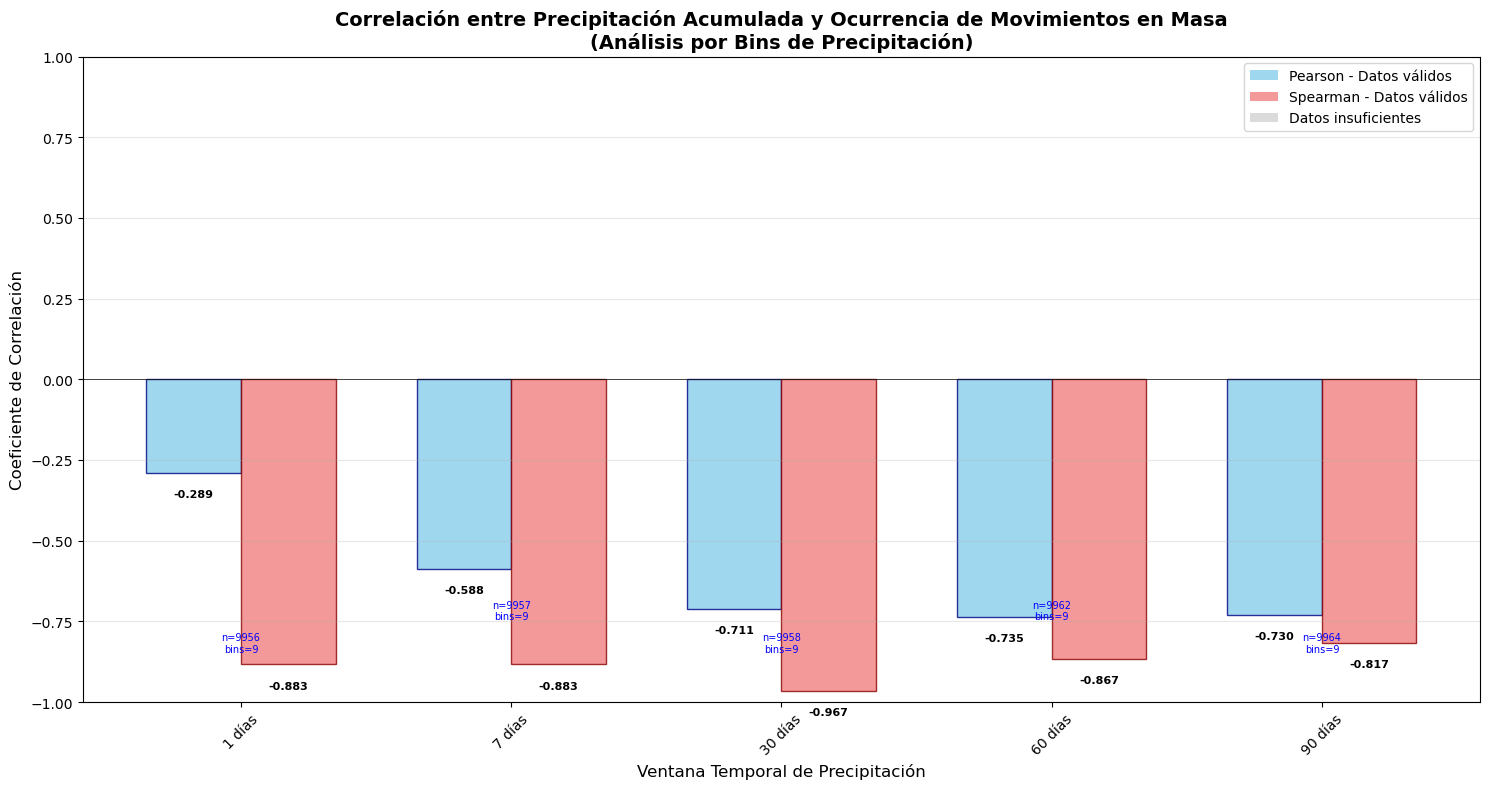


TABLA DE CORRELACIONES PRECIPITACIÓN vs OCURRENCIA DE MM
Variable Pearson Spearman P_Pearson P_Spearman  N_datos  N_bins
  1 días -0.2891  -0.8833    0.4506     0.0016     9956       9
  7 días -0.5877  -0.8833    0.0961     0.0016     9957       9
 30 días -0.7110  -0.9667    0.0318     0.0000     9958       9
 60 días -0.7352  -0.8667    0.0240     0.0025     9962       9
 90 días -0.7304  -0.8167    0.0254     0.0072     9964       9

INTERPRETACIÓN DE RESULTADOS

EXPLICACIÓN DE COEFICIENTES:
• Pearson: Mide relaciones lineales entre precipitación y ocurrencia de MM
• Spearman: Mide relaciones monotónicas (no necesariamente lineales)
• Valores cercanos a +1: correlación positiva fuerte
• Valores cercanos a -1: correlación negativa fuerte
• Valores cercanos a 0: sin correlación lineal/monotónica

RESULTADOS PRINCIPALES:
• Mayor correlación lineal (Pearson): 60 días = -0.7352
• Mayor correlación monotónica (Spearman): 30 días = -0.9667

CONCLUSIÓN:
Basándose en las correlaciones de S

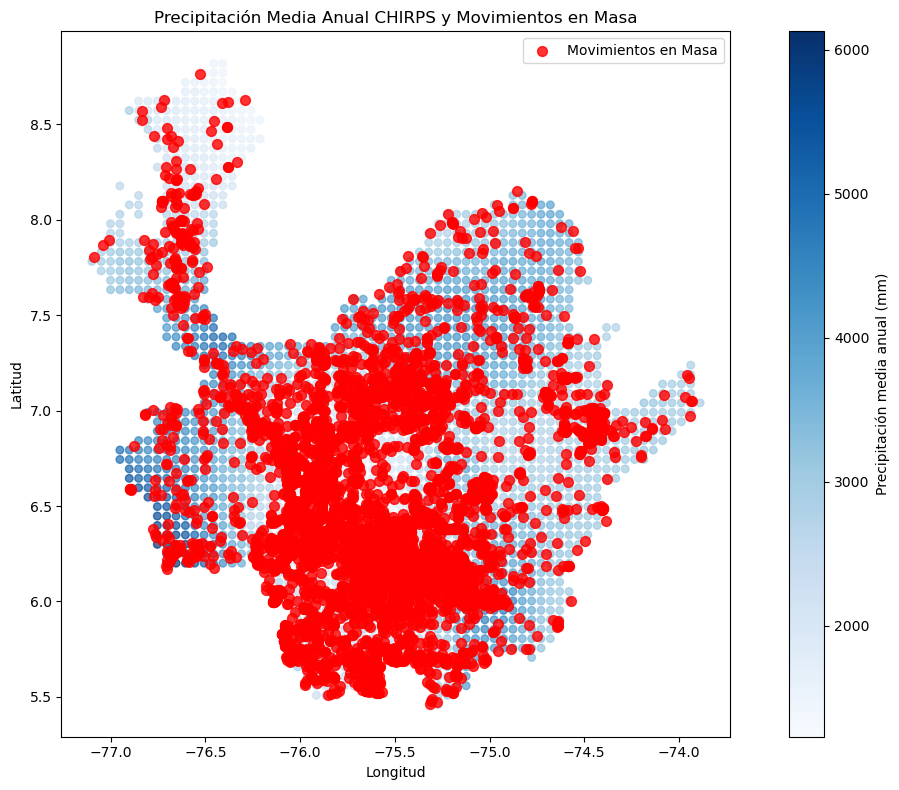

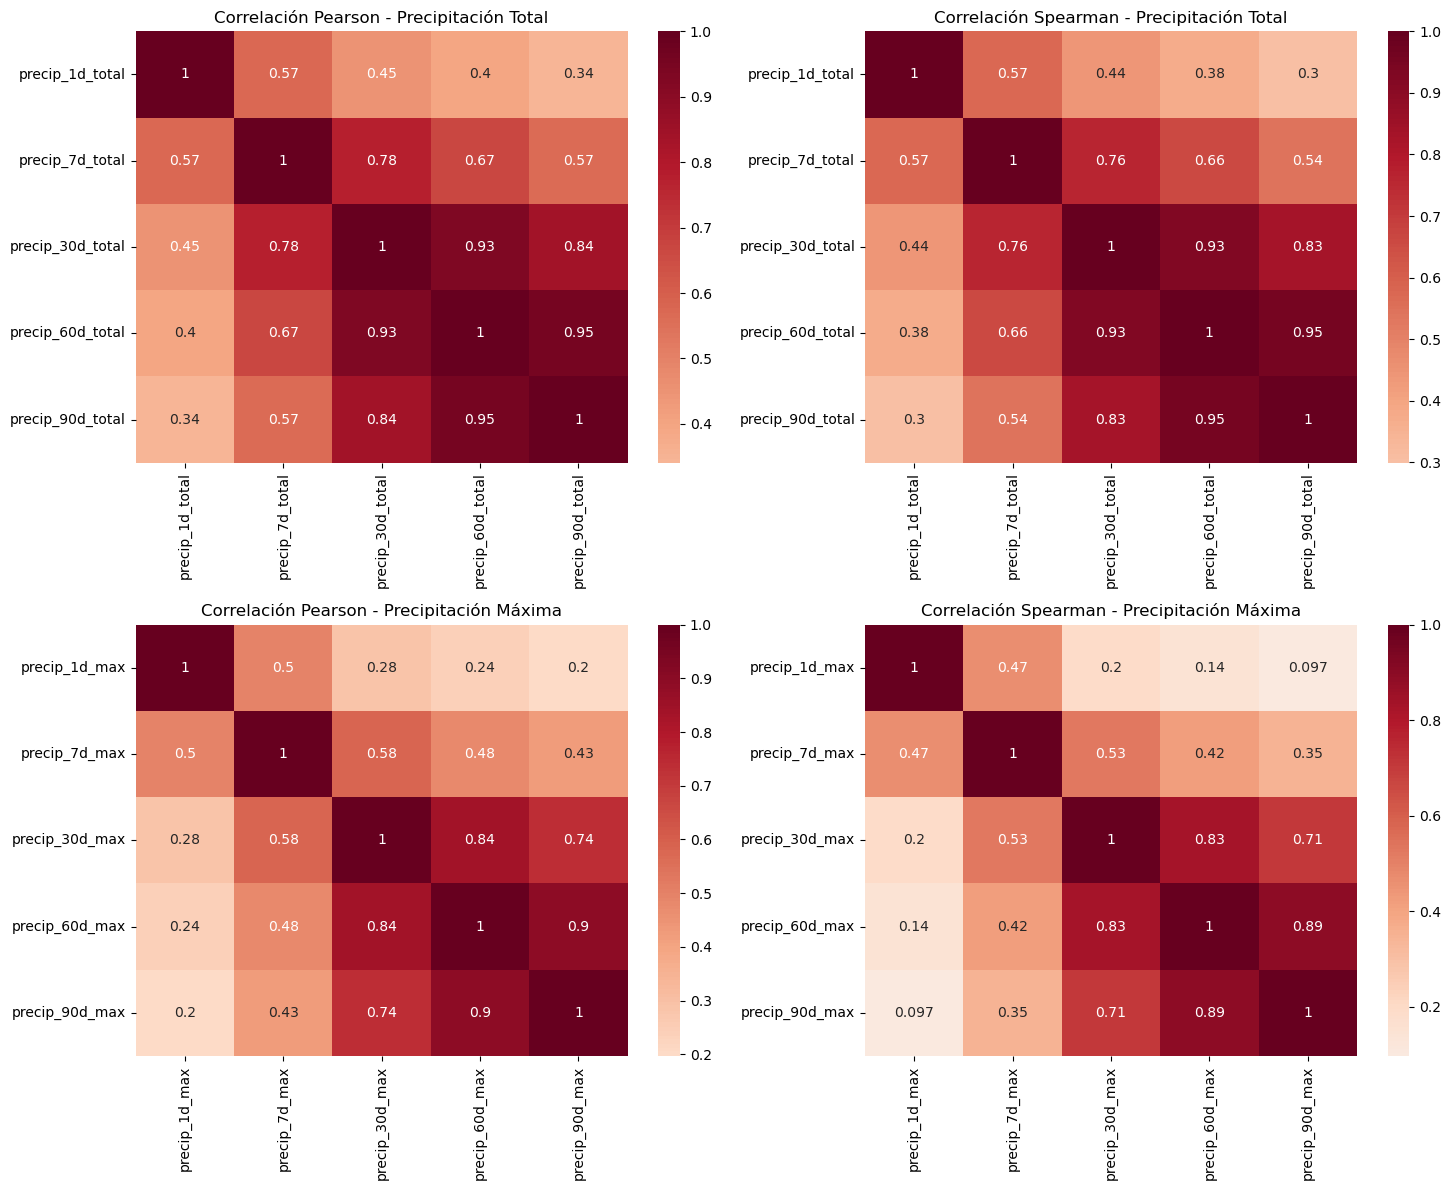

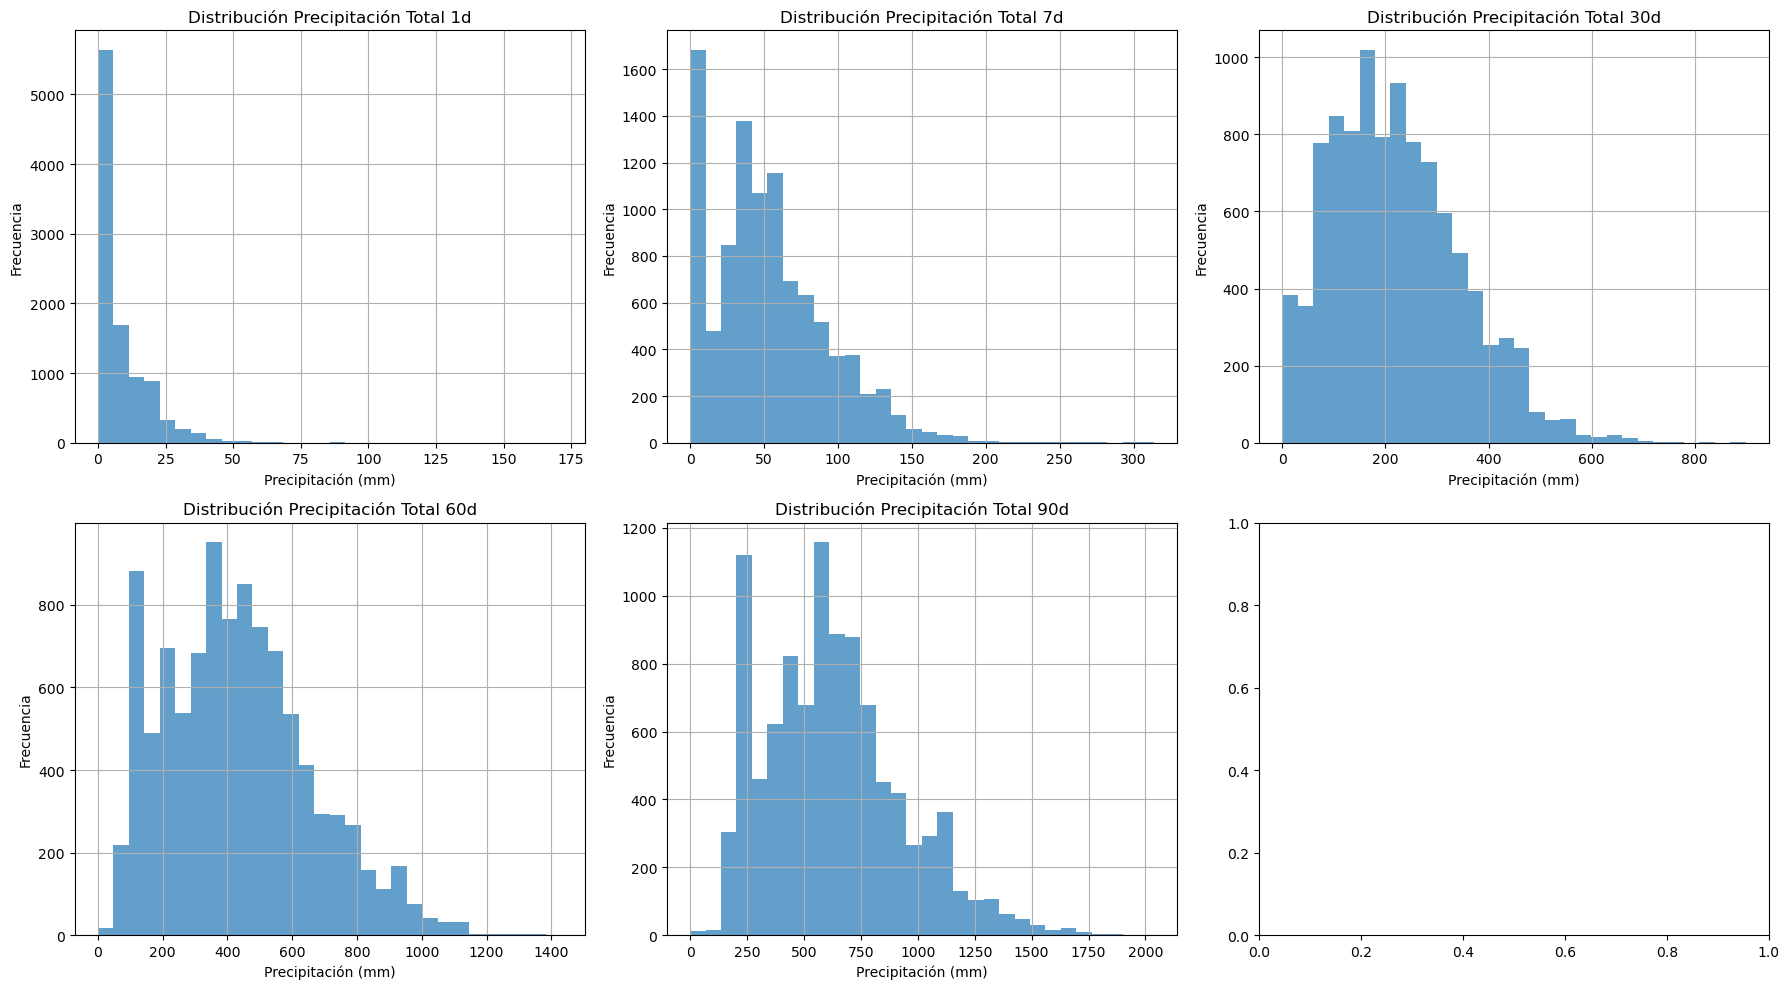

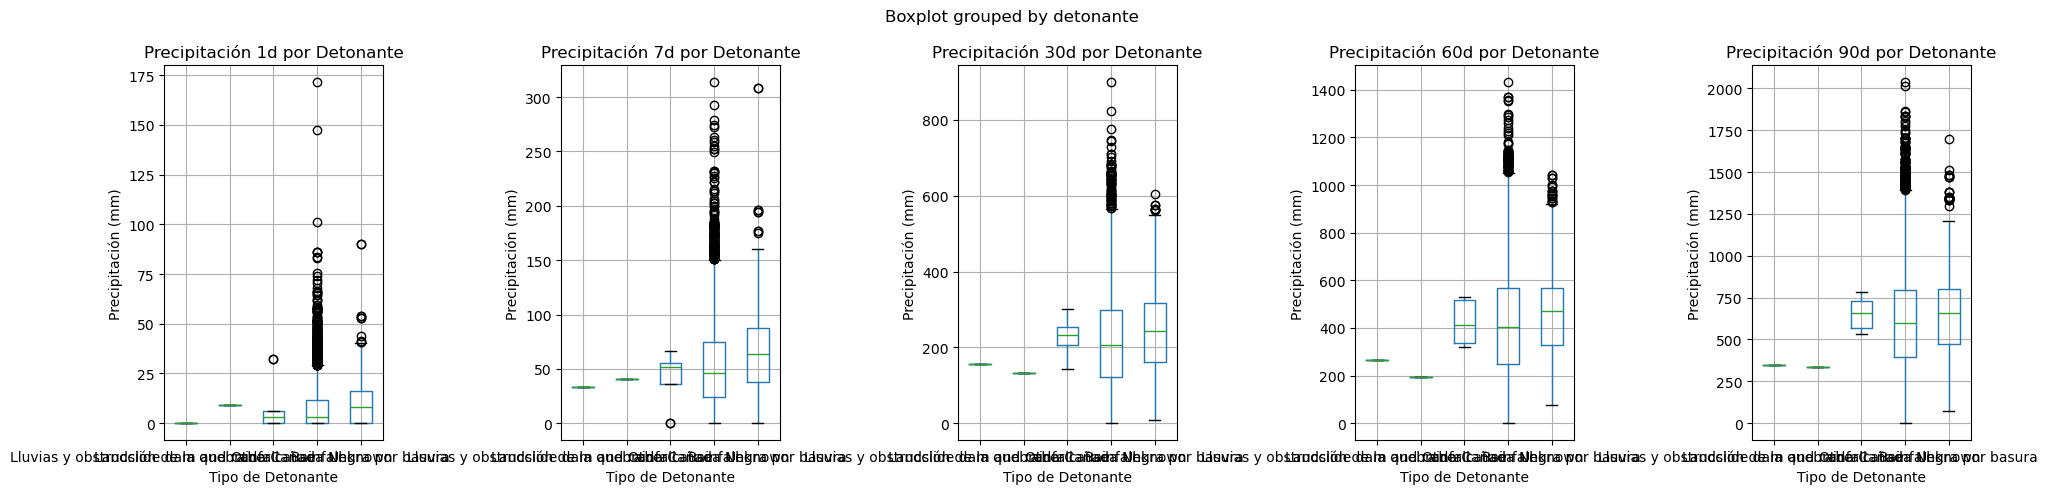


RESUMEN ESTADÍSTICO

Precipitación 1 días:
  Total - Media: 7.6mm, Mediana: 3.9mm, Std: 10.6mm
  Máxima - Media: 7.6mm

Precipitación 7 días:
  Total - Media: 53.1mm, Mediana: 47.8mm, Std: 39.9mm
  Máxima - Media: 20.5mm

Precipitación 30 días:
  Total - Media: 222.0mm, Mediana: 209.7mm, Std: 126.0mm
  Máxima - Media: 32.2mm

Precipitación 60 días:
  Total - Media: 431.4mm, Mediana: 412.3mm, Std: 226.3mm
  Máxima - Media: 37.6mm

Precipitación 90 días:
  Total - Media: 629.1mm, Mediana: 600.0mm, Std: 303.6mm
  Máxima - Media: 40.9mm

Correlaciones guardadas en: correlaciones_precipitacion_mm.csv

¡Análisis completado exitosamente!


ValueError: too many values to unpack (expected 2)

In [16]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr, spearmanr
import json
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 1. CARGAR Y PROCESAR DATOS CHIRPS
# ============================================================================

def cargar_datos_chirps(ruta_csv):
    """Carga y procesa los datos CHIRPS"""
    print("Cargando datos CHIRPS...")
    df = pd.read_csv(ruta_csv)
    
    # Extraer coordenadas desde el campo .geo
    df[["lon", "lat"]] = df[".geo"].apply(lambda x: pd.Series(json.loads(x)["coordinates"]))
    
    # Convertir fecha a datetime
    df["fecha"] = pd.to_datetime(df["fecha"])
    
    # Crear identificador único de píxel
    df['pixel_id'] = df.groupby(['lat', 'lon']).ngroup()
    
    print(f"Datos CHIRPS cargados: {len(df)} registros, {df['pixel_id'].nunique()} píxeles únicos")
    print(f"Rango temporal: {df['fecha'].min()} a {df['fecha'].max()}")
    
    return df

def crear_grilla_pixeles(df_chirps):
    """Crear DataFrame con información de píxeles únicos"""
    pixeles = df_chirps[['pixel_id', 'lat', 'lon']].drop_duplicates().reset_index(drop=True)
    
    # Crear GeoDataFrame de píxeles
    geometry = [Point(xy) for xy in zip(pixeles.lon, pixeles.lat)]
    gdf_pixeles = gpd.GeoDataFrame(pixeles, geometry=geometry, crs="EPSG:4326")
    
    return pixeles, gdf_pixeles

# ============================================================================
# 2. CARGAR Y PROCESAR INVENTARIO DE MM
# ============================================================================

def cargar_inventario_mm(ruta_inv):
    """Carga y procesa el inventario de movimientos en masa"""
    print("\nCargando inventario de MM...")
    df_inv = pd.read_csv(ruta_inv)
    
    # Mostrar las primeras columnas para verificar formato
    print("Columnas disponibles:", df_inv.columns.tolist())
    print("Primeras filas:")
    print(df_inv.head(10))
    
    # Procesar fechas - CORREGIR: parece que las fechas son de 2024, no 2025
    # Intentar múltiples formatos de fecha
    df_inv['fecha_evento'] = None
    
    if 'Fecha_Limpia' in df_inv.columns:
        # Primero intentar como 2024
        df_inv['fecha_evento'] = pd.to_datetime(df_inv['Fecha_Limpia'].astype(str).str.replace('24', '24'), 
                                              format='%Y-%m-%d', errors='coerce')
        # Si no funciona, intentar formato dd-mm-yy pero interpretando como 2024
        mask_null = df_inv['fecha_evento'].isnull()
        if mask_null.any():
            fechas_alt = pd.to_datetime(df_inv.loc[mask_null, 'Fecha_Limpia'].astype(str).str.replace('-24', '-24'), 
                                       format='%d-%m-%y', errors='coerce')
            df_inv.loc[mask_null, 'fecha_evento'] = fechas_alt
    
    # También intentar con la columna 'Fecha' si existe
    if 'Fecha' in df_inv.columns:
        mask_null = df_inv['fecha_evento'].isnull()
        if mask_null.any():
            fechas_fecha = pd.to_datetime(df_inv.loc[mask_null, 'Fecha'].astype(str).str.replace('24', '24'), 
                                         format='%d-%m-%y', errors='coerce')
            df_inv.loc[mask_null, 'fecha_evento'] = fechas_fecha
    
    print(f"Fechas procesadas inicialmente: {df_inv['fecha_evento'].notna().sum()} de {len(df_inv)}")
    print("Rango de fechas detectado:", df_inv['fecha_evento'].min(), "a", df_inv['fecha_evento'].max())
    
    # Limpiar coordenadas
    df_inv['lat'] = pd.to_numeric(df_inv['LAT'], errors='coerce')
    df_inv['lon'] = pd.to_numeric(df_inv['LONG'], errors='coerce')
    
    # Mostrar estadísticas antes de filtrar
    print(f"Coordenadas válidas: {df_inv[['lat', 'lon']].notna().all(axis=1).sum()} de {len(df_inv)}")
    print(f"Fechas válidas: {df_inv['fecha_evento'].notna().sum()} de {len(df_inv)}")
    
    # Filtrar datos válidos (permitir algunos NaN en otras columnas)
    mask_validos = (df_inv['lat'].notna() & 
                    df_inv['lon'].notna() & 
                    df_inv['fecha_evento'].notna())
    
    df_inv = df_inv[mask_validos].reset_index(drop=True)
    
    # Rellenar valores faltantes en columnas categóricas
    df_inv['Tipo'] = df_inv['Tipo'].fillna('Unknown')
    df_inv['Detonante'] = df_inv['Detonante'].fillna('Unknown')
    
    print(f"MM procesados: {len(df_inv)} eventos válidos")
    if len(df_inv) > 0:
        print(f"Rango temporal MM: {df_inv['fecha_evento'].min()} a {df_inv['fecha_evento'].max()}")
        print("Tipos de MM:", df_inv['Tipo'].value_counts().to_dict())
        print("Detonantes:", df_inv['Detonante'].value_counts().to_dict())
    
    return df_inv

# ============================================================================
# 3. ASIGNACIÓN DE PÍXELES MÁS CERCANOS
# ============================================================================

def asignar_pixeles_mm(df_inv, pixeles):
    """Asigna a cada MM el píxel CHIRPS más cercano"""
    print("\nAsignando píxeles más cercanos a los MM...")
    
    # Coordenadas de los MM
    coords_mm = df_inv[['lat', 'lon']].values
    
    # Coordenadas de los píxeles CHIRPS
    coords_pixeles = pixeles[['lat', 'lon']].values
    
    # Calcular distancias y encontrar píxel más cercano
    distancias = cdist(coords_mm, coords_pixeles, metric='euclidean')
    indices_cercanos = np.argmin(distancias, axis=1)
    distancias_min = np.min(distancias, axis=1)
    
    # Asignar píxel más cercano
    df_inv['pixel_id'] = pixeles.iloc[indices_cercanos]['pixel_id'].values
    df_inv['pixel_lat'] = pixeles.iloc[indices_cercanos]['lat'].values
    df_inv['pixel_lon'] = pixeles.iloc[indices_cercanos]['lon'].values
    df_inv['distancia_pixel'] = distancias_min
    
    print(f"Distancia promedio al píxel más cercano: {distancias_min.mean():.4f}° ({distancias_min.mean()*111:.1f} km)")
    
    return df_inv

# ============================================================================
# 4. CÁLCULO DE PRECIPITACIÓN EN VENTANAS TEMPORALES
# ============================================================================

def calcular_precipitacion_ventanas(df_inv, df_chirps, ventanas=[1, 7, 30, 60, 90]):
    """Calcula precipitación acumulada en diferentes ventanas temporales"""
    print(f"\nCalculando precipitación para ventanas: {ventanas} días...")
    
    resultados = []
    
    for idx, row in df_inv.iterrows():
        if idx % 100 == 0:
            print(f"Procesando MM {idx+1}/{len(df_inv)}")
        
        pixel_id = row['pixel_id']
        fecha_evento = row['fecha_evento']
        
        # Filtrar datos del píxel específico
        datos_pixel = df_chirps[df_chirps['pixel_id'] == pixel_id].copy()
        
        if len(datos_pixel) == 0:
            continue
        
        # Calcular precipitación para cada ventana
        resultado = {
            'mm_id': idx,
            'pixel_id': pixel_id,
            'fecha_evento': fecha_evento,
            'lat_mm': row['lat'],
            'lon_mm': row['lon'],
            'pixel_lat': row['pixel_lat'],
            'pixel_lon': row['pixel_lon'],
            'distancia_pixel': row['distancia_pixel'],
            'tipo': row.get('Tipo', 'Unknown'),
            'detonante': row.get('Detonante', 'Unknown')
        }
        
        for ventana in ventanas:
            fecha_inicio = fecha_evento - pd.Timedelta(days=ventana-1)
            
            # Filtrar datos en la ventana temporal
            mask = (datos_pixel['fecha'] >= fecha_inicio) & (datos_pixel['fecha'] <= fecha_evento)
            datos_ventana = datos_pixel[mask]
            
            if len(datos_ventana) > 0:
                precip_total = datos_ventana['precipitacion'].sum()
                precip_max_dia = datos_ventana['precipitacion'].max()
                dias_con_lluvia = (datos_ventana['precipitacion'] > 0).sum()
                precip_promedio = datos_ventana['precipitacion'].mean()
            else:
                precip_total = np.nan
                precip_max_dia = np.nan
                dias_con_lluvia = 0
                precip_promedio = np.nan
            
            resultado[f'precip_{ventana}d_total'] = precip_total
            resultado[f'precip_{ventana}d_max'] = precip_max_dia
            resultado[f'precip_{ventana}d_promedio'] = precip_promedio
            resultado[f'dias_lluvia_{ventana}d'] = dias_con_lluvia
        
        resultados.append(resultado)
    
    df_resultados = pd.DataFrame(resultados)
    print(f"Calculada precipitación para {len(df_resultados)} MM")
    
    return df_resultados

# ============================================================================
# 5. ANÁLISIS DE CORRELACIONES
# ============================================================================

def analizar_correlaciones(df_resultados, ventanas=[1, 7, 30, 60, 90]):
    """Analiza correlaciones entre diferentes ventanas temporales"""
    print("\nAnalizando correlaciones...")
    
    if len(df_resultados) == 0:
        print("No hay datos para analizar correlaciones")
        return None, None, None
    
    # Preparar datos para correlaciones
    cols_precip_total = [f'precip_{v}d_total' for v in ventanas]
    cols_precip_max = [f'precip_{v}d_max' for v in ventanas]
    
    # Verificar que las columnas existan
    cols_total_existentes = [col for col in cols_precip_total if col in df_resultados.columns]
    cols_max_existentes = [col for col in cols_precip_max if col in df_resultados.columns]
    
    print(f"Columnas de precipitación total encontradas: {cols_total_existentes}")
    print(f"Columnas de precipitación máxima encontradas: {cols_max_existentes}")
    
    if len(cols_total_existentes) < 2:
        print("Insuficientes columnas de precipitación para correlaciones")
        return None, None, None
    
    # Matrices de correlación
    df_total = df_resultados[cols_total_existentes].dropna()
    df_max = df_resultados[cols_max_existentes].dropna()
    
    print(f"Datos válidos para correlación total: {len(df_total)}")
    print(f"Datos válidos para correlación máxima: {len(df_max)}")
    
    if len(df_total) < 2:
        print("No hay suficientes datos para calcular correlaciones")
        return None, None, None
    
    # Correlaciones Pearson y Spearman
    try:
        corr_pearson_total = df_total.corr(method='pearson')
        corr_spearman_total = df_total.corr(method='spearman')
        
        correlaciones = {
            'pearson_total': corr_pearson_total,
            'spearman_total': corr_spearman_total
        }
        
        if len(df_max) >= 2:
            corr_pearson_max = df_max.corr(method='pearson')
            corr_spearman_max = df_max.corr(method='spearman')
            correlaciones['pearson_max'] = corr_pearson_max
            correlaciones['spearman_max'] = corr_spearman_max
        
        return correlaciones, df_total, df_max
        
    except Exception as e:
        print(f"Error calculando correlaciones: {e}")
        return None, None, None


# ============================================================================
# 5.5. ANÁLISIS DE CORRELACIÓN PRECIPITACIÓN VS OCURRENCIA DE MM
# ============================================================================

def calcular_y_graficar_correlaciones(df_resultados, ventanas=[1, 3, 5, 7, 15, 20, 25, 30, 45, 60, 75, 90]):
    """
    Calcula y grafica correlaciones entre precipitación y ocurrencia de MM
    Usa lógica de bins para agrupar datos y evitar problemas con valores anómalos
    """
    print("\nCalculando correlaciones precipitación vs ocurrencia de MM...")
    
    if len(df_resultados) == 0:
        print("No hay datos para analizar correlaciones")
        return None, None
    
    # 1. Preparación de los datos
    cols_precip = [f'precip_{v}d_total' for v in ventanas]
    cols_existentes = [col for col in cols_precip if col in df_resultados.columns]
    
    if len(cols_existentes) == 0:
        print("No se encontraron columnas de precipitación")
        return None, None
    
    print(f"Analizando correlaciones para: {cols_existentes}")
    
    # 2. Diccionario para almacenar correlaciones
    correlaciones_dict = {}
    
    # 3. Procesar cada ventana temporal
    for col in cols_existentes:
        ventana = col.replace('precip_', '').replace('d_total', '')
        print(f"Procesando correlación para {ventana} días...")
        
        # Filtrar datos válidos
        mask_validos = (~df_resultados[col].isna()) & (df_resultados[col] >= 0) & (df_resultados[col] <= 2000)
        datos_validos = df_resultados[mask_validos]
        
        if len(datos_validos) < 5:
            print(f"   {ventana}d: Datos insuficientes (n={len(datos_validos)})")
            correlaciones_dict[col] = {
                'pearson': np.nan, 'p_pearson': np.nan,
                'spearman': np.nan, 'p_spearman': np.nan,
                'n_datos': len(datos_validos), 'n_bins': 0
            }
            continue
        
        try:
            valores_acum = datos_validos[col].values
            
            # Eliminar valores duplicados para crear bins únicos
            valores_unicos = np.unique(valores_acum)
            if len(valores_unicos) < 3:
                print(f"   {ventana}d: Datos sin variabilidad (n_únicos={len(valores_unicos)})")
                correlaciones_dict[col] = {
                    'pearson': 0.0, 'p_pearson': 1.0,
                    'spearman': 0.0, 'p_spearman': 1.0,
                    'n_datos': len(datos_validos), 'n_bins': len(valores_unicos)
                }
                continue
            
            # Crear bins basados en percentiles de los valores únicos
            percentiles = np.linspace(0, 100, min(10, len(valores_unicos)))
            bins = np.percentile(valores_unicos, percentiles)
            bins = np.unique(bins)  # Eliminar duplicados
            
            if len(bins) < 3:
                print(f"   {ventana}d: Insuficientes bins únicos (n_bins={len(bins)})")
                correlaciones_dict[col] = {
                    'pearson': 0.0, 'p_pearson': 1.0,
                    'spearman': 0.0, 'p_spearman': 1.0,
                    'n_datos': len(datos_validos), 'n_bins': len(bins)
                }
                continue
            
            # Crear DataFrame temporal para binning
            df_temp = datos_validos.copy()
            df_temp['bin_acum'] = pd.cut(df_temp[col], bins=bins, include_lowest=True, duplicates='drop')
            
            # Contar eventos por bin
            conteos = df_temp.groupby('bin_acum', observed=True).size().reset_index(name='count')
            conteos = conteos.dropna()
            
            if len(conteos) < 3:
                print(f"   {ventana}d: Insuficientes bins con datos (n_bins_datos={len(conteos)})")
                correlaciones_dict[col] = {
                    'pearson': 0.0, 'p_pearson': 1.0,
                    'spearman': 0.0, 'p_spearman': 1.0,
                    'n_datos': len(datos_validos), 'n_bins': len(conteos)
                }
                continue
            
            # Obtener valor medio de precipitación por bin
            conteos['valor_acum'] = conteos['bin_acum'].apply(
                lambda x: x.mid if hasattr(x, 'mid') and pd.notna(x) else np.nan
            )
            conteos = conteos.dropna()
            
            if len(conteos) < 3:
                print(f"   {ventana}d: Error en cálculo de valores medios")
                correlaciones_dict[col] = {
                    'pearson': np.nan, 'p_pearson': np.nan,
                    'spearman': np.nan, 'p_spearman': np.nan,
                    'n_datos': len(datos_validos), 'n_bins': 0
                }
                continue
            
            # Obtener arrays para correlación
            x = conteos['valor_acum'].values  # Precipitación media por bin
            y = conteos['count'].values       # Conteo de MM por bin
            
            # Calcular correlaciones
            pearson_r, pearson_p = np.nan, np.nan
            spearman_r, spearman_p = np.nan, np.nan
            
            # Pearson
            try:
                if np.std(x) > 0 and np.std(y) > 0:
                    pearson_r, pearson_p = pearsonr(x, y)
                else:
                    pearson_r, pearson_p = 0.0, 1.0
            except Exception as e:
                print(f"   Error Pearson {ventana}d: {e}")
                pearson_r, pearson_p = np.nan, np.nan
            
            # Spearman
            try:
                if len(np.unique(x)) > 1 and len(np.unique(y)) > 1:
                    spearman_r, spearman_p = spearmanr(x, y)
                else:
                    spearman_r, spearman_p = 0.0, 1.0
            except Exception as e:
                print(f"   Error Spearman {ventana}d: {e}")
                spearman_r, spearman_p = np.nan, np.nan
            
            # Almacenar resultados
            correlaciones_dict[col] = {
                'pearson': pearson_r,
                'p_pearson': pearson_p,
                'spearman': spearman_r,
                'p_spearman': spearman_p,
                'n_datos': len(datos_validos),
                'n_bins': len(conteos)
            }
            
            print(f"   {ventana}d: Pearson={pearson_r:.3f}, Spearman={spearman_r:.3f}, n={len(datos_validos)}, bins={len(conteos)}")
            
        except Exception as e:
            print(f"   Error general en {ventana}d: {e}")
            correlaciones_dict[col] = {
                'pearson': np.nan, 'p_pearson': np.nan,
                'spearman': np.nan, 'p_spearman': np.nan,
                'n_datos': 0, 'n_bins': 0
            }
    
    if not correlaciones_dict:
        print("No se pudieron calcular correlaciones")
        return None, None
    
    # 4. Crear DataFrame de resultados - incluir TODAS las ventanas
    resultados_corr = []
    for ventana in ventanas:
        col = f'precip_{ventana}d_total'
        
        if col in correlaciones_dict:
            valores = correlaciones_dict[col]
            resultados_corr.append({
                'Variable': f'{ventana} días',
                'Pearson': valores['pearson'],
                'Spearman': valores['spearman'],
                'P_Pearson': valores['p_pearson'],
                'P_Spearman': valores['p_spearman'],
                'N_datos': valores['n_datos'],
                'N_bins': valores['n_bins']
            })
        else:
            # Agregar fila con NaN para ventanas no procesadas
            resultados_corr.append({
                'Variable': f'{ventana} días',
                'Pearson': np.nan,
                'Spearman': np.nan,
                'P_Pearson': np.nan,
                'P_Spearman': np.nan,
                'N_datos': 0,
                'N_bins': 0
            })
    
    df_correlaciones = pd.DataFrame(resultados_corr)
    
    # 5. Preparar datos para visualización
    df_viz = df_correlaciones.copy()
    
    # Rellenar NaN con 0 solo para visualización
    df_viz['pearson_viz'] = df_viz['Pearson'].fillna(0)
    df_viz['spearman_viz'] = df_viz['Spearman'].fillna(0)
    
    # Crear colores basados en si hay datos válidos
    colors_pearson = ['skyblue' if not pd.isna(r) else 'lightgray' for r in df_viz['Pearson']]
    colors_spearman = ['lightcoral' if not pd.isna(r) else 'lightgray' for r in df_viz['Spearman']]
    
    # 6. Generar gráfica de barras doble
    fig, ax = plt.subplots(figsize=(15, 8))
    
    x_pos = np.arange(len(df_viz))
    width = 0.35
    
    # Barras Pearson
    bars1 = ax.bar(x_pos - width/2, df_viz['pearson_viz'], 
                   width, label='Pearson', alpha=0.8, color=colors_pearson, edgecolor='navy')
    
    # Barras Spearman
    bars2 = ax.bar(x_pos + width/2, df_viz['spearman_viz'], 
                   width, label='Spearman', alpha=0.8, color=colors_spearman, edgecolor='darkred')
    
    # Personalizar gráfica
    ax.set_xlabel('Ventana Temporal de Precipitación', fontsize=12)
    ax.set_ylabel('Coeficiente de Correlación', fontsize=12)
    ax.set_title('Correlación entre Precipitación Acumulada y Ocurrencia de Movimientos en Masa\n(Análisis por Bins de Precipitación)', 
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(df_viz['Variable'], rotation=45)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(-1, 1)
    
    # Línea horizontal en Y=0
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    
    # Añadir valores en las barras
    for i, (v_orig_p, v_viz_p, v_orig_s, v_viz_s, n_datos, n_bins) in enumerate(zip(
        df_viz['Pearson'], df_viz['pearson_viz'], 
        df_viz['Spearman'], df_viz['spearman_viz'],
        df_viz['N_datos'], df_viz['N_bins'])):
        
        # Valores Pearson
        if not pd.isna(v_orig_p):
            ax.text(i - width/2, v_viz_p + 0.02 if v_viz_p > 0 else v_viz_p - 0.05, 
                   f'{v_orig_p:.3f}', ha='center', va='bottom' if v_viz_p > 0 else 'top', 
                   fontweight='bold', fontsize=8)
        else:
            ax.text(i - width/2, 0.02, 'N/A', ha='center', va='bottom', 
                   fontweight='bold', fontsize=8, color='red')
        
        # Valores Spearman
        if not pd.isna(v_orig_s):
            ax.text(i + width/2, v_viz_s + 0.02 if v_viz_s > 0 else v_viz_s - 0.05, 
                   f'{v_orig_s:.3f}', ha='center', va='bottom' if v_viz_s > 0 else 'top', 
                   fontweight='bold', fontsize=8)
        else:
            ax.text(i + width/2, 0.02, 'N/A', ha='center', va='bottom', 
                   fontweight='bold', fontsize=8, color='red')
        
        # Información adicional en la parte inferior
        if n_datos > 0:
            ax.text(i, -0.85 + (i % 2) * 0.1, f'n={n_datos}\nbins={n_bins}', 
                   ha='center', va='bottom', fontsize=7, color='blue')
    
    # Leyenda
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='skyblue', alpha=0.8, label='Pearson - Datos válidos'),
        Patch(facecolor='lightcoral', alpha=0.8, label='Spearman - Datos válidos'),
        Patch(facecolor='lightgray', alpha=0.8, label='Datos insuficientes')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.savefig('correlaciones_precipitacion_mm.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 6. Mostrar tabla de resultados
    print("\n" + "="*80)
    print("TABLA DE CORRELACIONES PRECIPITACIÓN vs OCURRENCIA DE MM")
    print("="*80)
    
    # Formatear tabla para mejor visualización
    df_mostrar = df_correlaciones.copy()
    df_mostrar['Pearson'] = df_mostrar['Pearson'].apply(lambda x: f"{x:.4f}")
    df_mostrar['Spearman'] = df_mostrar['Spearman'].apply(lambda x: f"{x:.4f}")
    df_mostrar['P_Pearson'] = df_mostrar['P_Pearson'].apply(lambda x: f"{x:.4f}")
    df_mostrar['P_Spearman'] = df_mostrar['P_Spearman'].apply(lambda x: f"{x:.4f}")
    
    print(df_mostrar.to_string(index=False))
    
    # 7. Explicación detallada de resultados
    print("\n" + "="*80)
    print("INTERPRETACIÓN DE RESULTADOS")
    print("="*80)
    
    # Encontrar la correlación más fuerte (en valor absoluto)
    max_pearson_idx = df_correlaciones['Pearson'].abs().idxmax()
    max_spearman_idx = df_correlaciones['Spearman'].abs().idxmax()
    
    max_pearson_var = df_correlaciones.loc[max_pearson_idx, 'Variable']
    max_pearson_val = df_correlaciones.loc[max_pearson_idx, 'Pearson']
    
    max_spearman_var = df_correlaciones.loc[max_spearman_idx, 'Variable']
    max_spearman_val = df_correlaciones.loc[max_spearman_idx, 'Spearman']
    
    print("\nEXPLICACIÓN DE COEFICIENTES:")
    print("• Pearson: Mide relaciones lineales entre precipitación y ocurrencia de MM")
    print("• Spearman: Mide relaciones monotónicas (no necesariamente lineales)")
    print("• Valores cercanos a +1: correlación positiva fuerte")
    print("• Valores cercanos a -1: correlación negativa fuerte")
    print("• Valores cercanos a 0: sin correlación lineal/monotónica")
    
    print("\nRESULTADOS PRINCIPALES:")
    print(f"• Mayor correlación lineal (Pearson): {max_pearson_var} = {max_pearson_val:.4f}")
    print(f"• Mayor correlación monotónica (Spearman): {max_spearman_var} = {max_spearman_val:.4f}")
    
    # Interpretación de ventanas temporales
    ventanas_cortas = [v for v in df_correlaciones['Variable'] if '1 día' in v or '7 días' in v]
    ventanas_largas = [v for v in df_correlaciones['Variable'] if '30 días' in v or '60 días' in v or '90 días' in v]
    
    if ventanas_cortas and ventanas_largas:
        corr_cortas_spearman = df_correlaciones[df_correlaciones['Variable'].isin(ventanas_cortas)]['Spearman'].abs().max()
        corr_largas_spearman = df_correlaciones[df_correlaciones['Variable'].isin(ventanas_largas)]['Spearman'].abs().max()
        
        if corr_cortas_spearman > corr_largas_spearman:
            tipo_detonante = "precipitación intensa de corto plazo"
        else:
            tipo_detonante = "precipitación acumulada de largo plazo"
    else:
        tipo_detonante = "se requiere más análisis"
    
    print(f"\nCONCLUSIÓN:")
    print(f"Basándose en las correlaciones de Spearman, {tipo_detonante}")
    print("parece ser el principal detonante de movimientos en masa en la región analizada.")
    
    return df_correlaciones, correlaciones_dict
# ============================================================================
# 6. VISUALIZACIONES
# ============================================================================

def crear_visualizaciones(df_resultados, correlaciones, df_chirps, gdf_pixeles, ventanas=[1, 7, 30, 60, 90]):
    """Genera visualizaciones del análisis"""
    print("\nGenerando visualizaciones...")
    
    # 1. Mapa de precipitación media anual y MM
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Calcular precipitación media anual por píxel
    precip_anual = df_chirps.groupby(['pixel_id', 'lat', 'lon', df_chirps['fecha'].dt.year])['precipitacion'].sum().reset_index()
    precip_media = precip_anual.groupby(['pixel_id', 'lat', 'lon'])['precipitacion'].mean().reset_index()
    
    # Crear GeoDataFrame de precipitación
    geometry_precip = [Point(xy) for xy in zip(precip_media.lon, precip_media.lat)]
    gdf_precip = gpd.GeoDataFrame(precip_media, geometry=geometry_precip, crs="EPSG:4326")
    
    # Plot precipitación
    gdf_precip.plot(column='precipitacion', cmap='Blues', markersize=30, alpha=0.7, 
                    legend=True, ax=ax, legend_kwds={'label': 'Precipitación media anual (mm)'})
    
    # Plot MM
    if len(df_resultados) > 0:
        geometry_mm = [Point(xy) for xy in zip(df_resultados.lon_mm, df_resultados.lat_mm)]
        gdf_mm = gpd.GeoDataFrame(df_resultados, geometry=geometry_mm, crs="EPSG:4326")
        gdf_mm.plot(color='red', markersize=50, ax=ax, alpha=0.8, label='Movimientos en Masa')
        ax.legend()
    
    ax.set_title('Precipitación Media Anual CHIRPS y Movimientos en Masa')
    ax.set_xlabel('Longitud')
    ax.set_ylabel('Latitud')
    plt.tight_layout()
    plt.savefig('mapa_precipitacion_mm.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Matrices de correlación
    if correlaciones:
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Correlaciones precipitación total
        sns.heatmap(correlaciones['pearson_total'], annot=True, cmap='RdBu_r', center=0, ax=axes[0,0])
        axes[0,0].set_title('Correlación Pearson - Precipitación Total')
        
        sns.heatmap(correlaciones['spearman_total'], annot=True, cmap='RdBu_r', center=0, ax=axes[0,1])
        axes[0,1].set_title('Correlación Spearman - Precipitación Total')
        
        # Correlaciones precipitación máxima
        sns.heatmap(correlaciones['pearson_max'], annot=True, cmap='RdBu_r', center=0, ax=axes[1,0])
        axes[1,0].set_title('Correlación Pearson - Precipitación Máxima')
        
        sns.heatmap(correlaciones['spearman_max'], annot=True, cmap='RdBu_r', center=0, ax=axes[1,1])
        axes[1,1].set_title('Correlación Spearman - Precipitación Máxima')
        
        plt.tight_layout()
        plt.savefig('correlaciones_precipitacion.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # 3. Distribuciones de precipitación por ventana temporal
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    for i, ventana in enumerate(ventanas):
        col_total = f'precip_{ventana}d_total'
        col_max = f'precip_{ventana}d_max'
        
        if col_total in df_resultados.columns and col_max in df_resultados.columns:
            # Histograma precipitación total
            df_resultados[col_total].dropna().hist(bins=30, alpha=0.7, ax=axes[i])
            axes[i].set_title(f'Distribución Precipitación Total {ventana}d')
            axes[i].set_xlabel('Precipitación (mm)')
            axes[i].set_ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.savefig('distribuciones_precipitacion.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 4. Boxplots por tipo de detonante
    if 'detonante' in df_resultados.columns:
        fig, axes = plt.subplots(1, len(ventanas), figsize=(20, 5))
        
        for i, ventana in enumerate(ventanas):
            col = f'precip_{ventana}d_total'
            if col in df_resultados.columns:
                df_resultados.boxplot(column=col, by='detonante', ax=axes[i])
                axes[i].set_title(f'Precipitación {ventana}d por Detonante')
                axes[i].set_xlabel('Tipo de Detonante')
                axes[i].set_ylabel('Precipitación (mm)')
        
        plt.tight_layout()
        plt.savefig('boxplots_detonante.png', dpi=300, bbox_inches='tight')
        plt.show()

# ============================================================================
# 7. FUNCIÓN PRINCIPAL ACTUALIZADA
# ============================================================================

def main():
    """Función principal que ejecuta todo el análisis"""
    # Rutas de archivos
    ruta_csv = r"E:\Trabajo\Analisis_Datos\Proyecto\Datos\Chirps\Precipitacion_Diaria_ANT2000.csv"
    ruta_inv = r"E:\Trabajo\Analisis_Datos\Proyecto\Datos\Inventario\CSV\INV3_filtrado.csv"
    
    # Ventanas temporales a analizar
    ventanas = [1,3,5, 7,15,20,25,30,45,60,75, 90]
    
    try:
        # 1. Cargar datos CHIRPS
        df_chirps = cargar_datos_chirps(ruta_csv)
        pixeles, gdf_pixeles = crear_grilla_pixeles(df_chirps)
        
        # 2. Cargar inventario MM
        df_inv = cargar_inventario_mm(ruta_inv)
        
        # 3. Asignar píxeles
        df_inv = asignar_pixeles_mm(df_inv, pixeles)
        
        # 4. Calcular precipitación en ventanas
        df_resultados = calcular_precipitacion_ventanas(df_inv, df_chirps, ventanas)
        
        # 5. Guardar resultados
        df_resultados.to_csv(r'E:\Trabajo\Analisis_Datos\Proyecto\Resultados\resultados_precipitacion_mm.csv', index=False)
        print(f"\nResultados guardados en: resultados_precipitacion_mm.csv")
        
        # 6. Análisis de correlaciones entre ventanas temporales
        correlaciones, df_total, df_max = analizar_correlaciones(df_resultados, ventanas)
        
        # 6.5. NUEVA FUNCIÓN: Análisis de correlación precipitación vs ocurrencia de MM
        df_correlaciones_mm, correlaciones_mm = calcular_y_graficar_correlaciones(df_resultados, ventanas)
        
        # 7. Generar visualizaciones
        crear_visualizaciones(df_resultados, correlaciones, df_chirps, gdf_pixeles, ventanas)
        
        # 8. Resumen estadístico
        print("\n" + "="*50)
        print("RESUMEN ESTADÍSTICO")
        print("="*50)
        
        for ventana in ventanas:
            col_total = f'precip_{ventana}d_total'
            col_max = f'precip_{ventana}d_max'
            
            if col_total in df_resultados.columns:
                media_total = df_resultados[col_total].mean()
                mediana_total = df_resultados[col_total].median()
                std_total = df_resultados[col_total].std()
                
                print(f"\nPrecipitación {ventana} días:")
                print(f"  Total - Media: {media_total:.1f}mm, Mediana: {mediana_total:.1f}mm, Std: {std_total:.1f}mm")
                
                if col_max in df_resultados.columns:
                    media_max = df_resultados[col_max].mean()
                    print(f"  Máxima - Media: {media_max:.1f}mm")
        
        # 9. Guardar también los resultados de correlación
        if df_correlaciones_mm is not None:
            df_correlaciones_mm.to_csv(r'E:\Trabajo\Analisis_Datos\Proyecto\Resultados\correlaciones_precipitacion_mm.csv', index=False)
            print(f"\nCorrelaciones guardadas en: correlaciones_precipitacion_mm.csv")
        
        print("\n¡Análisis completado exitosamente!")
        return df_resultados, correlaciones, df_correlaciones_mm
        
    except Exception as e:
        print(f"Error durante el análisis: {str(e)}")
        return None, None, None

# Ejecutar análisis
if __name__ == "__main__":
    resultados, correlaciones = main()